 Optimize the Eduati 2020 model using BNMPy optimizer

In the Eduati 2020 paper (doi: 10.15252/msb.209690, link: https://www.ncbi.nlm.nih.gov/pubmed/32073727), 
a logical model has been trained using drug response data to predict new treatment data using the CNOR-ODE tool.   
  
Here, we are trying to optimizie the model using the same data they provided, but with our PBN optimizer.

## Training data
Drug response data was obtained from GitHub repository: https://github.com/saezlab/ModelingMPS/tree/master/data/MIDAS_files

In [1]:
import sys
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
sys.path.append('./src')
import BNMPy
import Optimizer
# from BNMPy import PBN, BMatrix, booleanNetwork, vis
# from BNMPy.steady_state import SteadyStateCalculator
# from Optimizer.experiment_data import ExperimentData
# from Optimizer.parameter_optimizer import ParameterOptimizer
# from Optimizer.model_compressor import compress_model
# from Optimizer.sensitivity_analysis import sensitivity_analysis

network_file = '../input_files/Eduati2020_standardized_no_expand.txt'
data_aspc1_file = '../data/Eduati2020_AsPC1_cleaned_reduced.csv'
data_bxpc3_file = '../data/Eduati2020_BxPC3_cleaned_reduced.csv'

The data was cleaned by changing names of genes to a standard HGNC symbol, and convert to a format that complys with our ExperimentData.

In [10]:
# Load it in BNMPy
data_aspc1 = Optimizer.ExperimentData.load_from_csv(data_aspc1_file)
data_aspc1

[{'id': 1,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['EGFR'],
  'inhibitors_efficacy': [1.0],
  'measurements': {'CASP3': 0.317699657}},
 {'id': 2,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['JAK1'],
  'inhibitors_efficacy': [1.0],
  'measurements': {'CASP3': 0.270094786}},
 {'id': 3,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['MAP2K1'],
  'inhibitors_efficacy': [1.0],
  'measurements': {'CASP3': 0.240832496}},
 {'id': 4,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['AktM'],
  'inhibitors_efficacy': [1.0],
  'measurements': {'CASP3': 0.370602546}},
 {'id': 5,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['IKBKB'],
  'inhibitors_efficacy': [1.0],
  'measurements': {'CASP3': 0.400900604}},
 {'id': 6,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['PIK3CA'],
  'inhibitors_efficacy': [1.0],
  'measurements': {'CASP3': 0.369222631}},
 {'id': 7,
  'sti

In [3]:
Optimizer.ExperimentData.get_experiment_summary(data_aspc1)

{'num_experiments': 7,
 'unique_stimuli': ['TNF', 'EGF'],
 'unique_inhibitors': ['AktM', 'IKBKB', 'MAP2K1', 'PIK3CA', 'EGFR', 'JAK1'],
 'unique_measured_nodes': ['CASP3'],
 'value_ranges': {'CASP3': {'min': 0.240832496, 'max': 0.400900604}},
 'stimuli_efficacy_ranges': {'EGF': {'min': 1.0, 'max': 1.0},
  'TNF': {'min': 1.0, 'max': 1.0}},
 'inhibitors_efficacy_ranges': {'EGFR': {'min': 1.0, 'max': 1.0},
  'JAK1': {'min': 1.0, 'max': 1.0},
  'MAP2K1': {'min': 1.0, 'max': 1.0},
  'AktM': {'min': 1.0, 'max': 1.0},
  'IKBKB': {'min': 1.0, 'max': 1.0},
  'PIK3CA': {'min': 1.0, 'max': 1.0}}}

## Define alternative rule for PBN

We will just use self-loop as the alternative rules for now.  

E.g., for `TNFRSF1A = NFKB1 | TNF` in BN, its rule in PBN will be: 
   
`TNFRSF1A = NFKB1 | TNF, p`  
`TNFRSF1A = TNFRSF1A, 1-p`   
where p is the probability to be optimized. We will just put a 0.5 here as placeholder.

In [2]:
with open(network_file, 'r') as f:
    bn_string = f.read()

pbn_string, nodes_to_optimize = BNMPy.BN2PBN(bn_string, prob=0.5, fixed_nodes=['CASP3'])
pbn = BNMPy.load_pbn_from_string(pbn_string)

print("PBN string:")
print(pbn_string)

No initial state provided, using a random initial state
PBN loaded successfully. There are 46 genes in the network.
PBN string:
AKT1 = AktM & AktP, 0.5
AKT1 = AKT1, 0.5
APAF1 = TP53, 0.5
APAF1 = APAF1, 0.5
APC = APAF1 & CASP9 & Mito | ! BIRC2, 0.5
APC = APC, 0.5
AktM = PDPK1 & PIP3, 0.5
AktM = AktM, 0.5
AktP = PDPK1 & PIP3, 0.5
AktP = AktP, 0.5
BAD = TP53 | ! RPS6KA1 | ! AKT1, 0.5
BAD = BAD, 0.5
BCL2L1 = ! TP53 | STAT3 | NFKB1 | ! BAD, 0.5
BCL2L1 = BCL2L1, 0.5
BID = MAPK8 & TP53 | CASP8 & TP53 | ! BCL2L1, 0.5
BID = BID, 0.5
BIRC2 = ! CASP3 & ! CASP6 | NFKB1 | ! Mito, 0.5
BIRC2 = BIRC2, 0.5
CASP12 = CASP7, 0.5
CASP12 = CASP12, 0.5
CASP3 = ! BIRC2 | CASP8 | CASP6 | APC, 1
CASP6 = ! BIRC2 | CASP3, 0.5
CASP6 = CASP6, 0.5
CASP7 = ! BIRC2 | CASP8 | APC, 0.5
CASP7 = CASP7, 0.5
CASP8 = complexIIB | complexIIA | CASP6, 0.5
CASP8 = CASP8, 0.5
CASP9 = ! BIRC2 | ! MAPK1 | CASP3 | CASP12 | ! AKT1, 0.5
CASP9 = CASP9, 0.5
CFLAR = NFKB1, 0.5
CFLAR = CFLAR, 0.5
EGF = EGF, 1
EGFR = EGF, 0.5
EGFR = EGFR,

In [3]:
print(f"There are {len(nodes_to_optimize)} nodes to optimize:")
print(nodes_to_optimize)

There are 42 nodes to optimize:
['AKT1', 'APAF1', 'APC', 'AktM', 'AktP', 'BAD', 'BCL2L1', 'BID', 'BIRC2', 'CASP12', 'CASP6', 'CASP7', 'CASP8', 'CASP9', 'CFLAR', 'EGFR', 'IKBKB', 'JAK1', 'KRAS', 'MAP2K1', 'MAP2K4', 'MAP3K1', 'MAP3K14', 'MAPK1', 'MAPK8', 'MDM2', 'Mito', 'NFKB1', 'NFKBIA', 'PIK3CA', 'PIP3', 'PTEN', 'RAF1', 'RPS6KA1', 'SOS1', 'STAT3', 'TNFAIP3', 'TNFRSF1A', 'TP53', 'complexI', 'complexIIA', 'complexIIB']


## KG extension

In [2]:
network = BNMPy.load_network_from_file(network_file)
genes = network.nodeDict.keys()

No initial state provided, using a random initial state
Network loaded successfully. There are 46 genes in the network.


In [22]:
# get the knowledge graph-derived network
KG_string, relations = BNMPy.load_signor_network(genes, joiner='inhibitor_wins')
print(KG_string)

number of genes found: 39
[207, 317, 324, 572, 598, 637, 329, 100506742, 836, 839, 840, 841, 842, 8837, 1950, 1956, 3551, 3716, 3845, 5604, 6416, 4214, 9020, 5594, 5599, 4193, 4790, 4792, 5170, 5290, 5728, 5894, 6195, 6654, 6774, 7124, 7128, 7132, 7157]
AKT1 = (!CASP3 & !PTEN) & (MAPK8 | PDPK1 | AKT1 | TNF | PIK3CA) # Scores: MAPK8_activate:0.428; PDPK1_activate:0.749; AKT1_activate:0.2; CASP3_inhibit:0.602; PTEN_inhibit:0.634; TNF_activate:0.48; PIK3CA_activate:0.816
APAF1 = !BCL2L1 # Scores: BCL2L1_inhibit:0.841
APC = APC
BAD = (!MAPK8 & !AKT1 & !MAPK1 & !RAF1 & !RPS6KA1 & !IKBKB) & (CASP3 | BCL2L1) # Scores: MAPK8_inhibit:0.686; AKT1_inhibit:0.823; MAPK1_inhibit:0.459; CASP3_activate:0.534; RAF1_inhibit:0.66; RPS6KA1_inhibit:0.396; IKBKB_inhibit:0.263; BCL2L1_activate:0.849
BCL2L1 = (!MAPK8 & !BAD & !IKBKB & !BID) # Scores: MAPK8_inhibit:0.774; BAD_inhibit:0.849; IKBKB_inhibit:0.339; BID_inhibit:0.859
BID = !ITCH & (MAPK8 | TP53 | CASP8) # Scores: MAPK8_activate:0.594; TP53_activate

In [61]:
# get the knowledge graph-derived network
KG_string, relations = BNMPy.load_signor_network(genes, joiner='&')
print(KG_string)

number of genes found: 39
[207, 317, 324, 572, 598, 637, 329, 100506742, 836, 839, 840, 841, 842, 8837, 1950, 1956, 3551, 3716, 3845, 5604, 6416, 4214, 9020, 5594, 5599, 4193, 4790, 4792, 5170, 5290, 5728, 5894, 6195, 6654, 6774, 7124, 7128, 7132, 7157]
AKT1 = (MAPK8) & (PDPK1) & (AKT1) & (! CASP3) & (! PTEN) & (TNF) & (PIK3CA) # Scores: MAPK8_activate:0.428; PDPK1_activate:0.749; AKT1_activate:0.2; CASP3_inhibit:0.602; PTEN_inhibit:0.634; TNF_activate:0.48; PIK3CA_activate:0.816
APAF1 = (! BCL2L1) # Scores: BCL2L1_inhibit:0.841
APC = APC
BAD = (! MAPK8) & (! AKT1) & (! MAPK1) & (CASP3) & (! RAF1) & (! RPS6KA1) & (! IKBKB) & (BCL2L1) # Scores: MAPK8_inhibit:0.686; AKT1_inhibit:0.823; MAPK1_inhibit:0.459; CASP3_activate:0.534; RAF1_inhibit:0.66; RPS6KA1_inhibit:0.396; IKBKB_inhibit:0.263; BCL2L1_activate:0.849
BCL2L1 = (! MAPK8) & (! BAD) & (! IKBKB) & (! BID) # Scores: MAPK8_inhibit:0.774; BAD_inhibit:0.849; IKBKB_inhibit:0.339; BID_inhibit:0.859
BID = (MAPK8) & (TP53) & (CASP8) & (! I

In [23]:
# get the knowledge graph-derived network
KG_string, relations = BNMPy.load_signor_network(genes, joiner='&', score_cutoff=0.5)
print(KG_string)

number of genes found: 39
[207, 317, 324, 572, 598, 637, 329, 100506742, 836, 839, 840, 841, 842, 8837, 1950, 1956, 3551, 3716, 3845, 5604, 6416, 4214, 9020, 5594, 5599, 4193, 4790, 4792, 5170, 5290, 5728, 5894, 6195, 6654, 6774, 7124, 7128, 7132, 7157]
AKT1 = (! CASP3) & (PDPK1) & (! PTEN) & (PIK3CA) # Scores: CASP3_inhibit:0.602; PDPK1_activate:0.749; PTEN_inhibit:0.634; PIK3CA_activate:0.816
APAF1 = (! BCL2L1) # Scores: BCL2L1_inhibit:0.841
APC = APC
BAD = (! MAPK8) & (CASP3) & (! AKT1) & (! RAF1) & (BCL2L1) # Scores: MAPK8_inhibit:0.686; CASP3_activate:0.534; AKT1_inhibit:0.823; RAF1_inhibit:0.66; BCL2L1_activate:0.849
BCL2L1 = (! MAPK8) & (! BAD) & (! BID) # Scores: MAPK8_inhibit:0.774; BAD_inhibit:0.849; BID_inhibit:0.859
BID = (MAPK8) & (TP53) & (CASP8) # Scores: MAPK8_activate:0.594; TP53_activate:0.517; CASP8_activate:0.88
BIRC2 = BIRC2
CASP3 = (CASP9) & (CASP8) # Scores: CASP9_activate:0.639; CASP8_activate:0.727
CASP6 = (CASP3) & (CASP8) # Scores: CASP3_activate:0.619; CASP8

In [24]:
KG = BNMPy.load_network_from_string(KG_string)
# Merge the networks using PBN
pbn_string = BNMPy.merge_networks([network, KG], method="PBN", prob=0.9)
pbn = BNMPy.load_pbn_from_string(pbn_string)
print(pbn_string)

No initial state provided, using a random initial state
Network loaded successfully. There are 40 genes in the network.
No initial state provided, using a random initial state
PBN loaded successfully. There are 48 genes in the network.
AKT1 = !CASP3 & PDPK1 & PIK3CA & !PTEN, 0.1
AKT1 = AktM & AktP, 0.9
APAF1 = !BCL2L1, 0.1
APAF1 = TP53, 0.9
APC = !BIRC2 | ( APAF1 & CASP9 & Mito ), 0.9
APC = APC, 0.1
AktM = PDPK1 & PIP3, 1.0
AktP = PDPK1 & PIP3, 1.0
BAD = !AKT1 & BCL2L1 & CASP3 & !MAPK8 & !RAF1, 0.1
BAD = !AKT1 | !RPS6KA1 | TP53, 0.9
BCL2L1 = !BAD & !BID & !MAPK8, 0.1
BCL2L1 = !BAD | NFKB1 | STAT3 | !TP53, 0.9
BID = !BCL2L1 | ( CASP8 & TP53 ) | ( MAPK8 & TP53 ), 0.9
BID = CASP8 & MAPK8 & TP53, 0.1
BIRC2 = !Mito | NFKB1 | ( !CASP3 & !CASP6 ), 0.9
BIRC2 = BIRC2, 0.1
CASP12 = CASP7, 1.0
CASP3 = APC | !BIRC2 | CASP6 | CASP8, 0.9
CASP3 = CASP8 & CASP9, 0.1
CASP6 = !BIRC2 | CASP3, 0.9
CASP6 = CASP3 & CASP8, 0.1
CASP7 = APC | !BIRC2 | CASP8, 0.9
CASP7 = CASP8, 0.1
CASP8 = CASP6 & !CFLAR & !MAP

In [ ]:
BNMPy.vis_network(pbn, output_html="ExtendedPBN_Eduati2020.html", interactive=True, measured_nodes=measured_nodes, perturbed_nodes=perturbed_nodes)

## Sensitivity analysis

In [7]:
# importlib.reload(sys.modules['Optimizer.sensitivity_analysis'])
# from Optimizer.sensitivity_analysis import sensitivity_analysis
config = {
            'sensitivity_method': 'morris',  # 'morris', or 'sobol'
            'morris_trajectories': 20,       
            'sobol_samples': 512,                 
            'sobol_second_order': False,
            'steady_state': {
                'method': 'monte_carlo',
                'monte_carlo_params': {
                    'n_runs': 2,                
                    'n_steps': 10000,          
                    'p_noise': 0.05
                }
            }
        }
results = sensitivity_analysis(
    network=pbn, 
    experiments=data_aspc1_file, 
    config=config, 
    top_n=10, 
    verbose=True
)

PBN SENSITIVITY ANALYSIS

Network information:
  - Total nodes: 46
  - Measured nodes: 1 (CASP3)
  - Analyzable nodes: 42
  - Experiments: 8

Using MORRIS sensitivity analysis method
  - Parallel processing: Enabled (14 workers)

Morris analysis setup:
  - Parameters: 42
  - Trajectories: 20
  - Total evaluations: ~860

Evaluating 860 parameter sets in parallel (14 workers)...


100%|██████████| 58/58 [20:18<00:00, 21.02s/it]  


Identifying top 10 sensitive nodes...

Top 10 sensitive nodes (by average Mean |Effect|):
--------------------------------------------------
1. CASP8           - Avg: 0.0320, Max: 0.0320, Std: nan
2. CASP6           - Avg: 0.0299, Max: 0.0299, Std: nan
3. BIRC2           - Avg: 0.0113, Max: 0.0113, Std: nan
4. CASP9           - Avg: 0.0109, Max: 0.0109, Std: nan
5. APAF1           - Avg: 0.0094, Max: 0.0094, Std: nan
6. TNFAIP3         - Avg: 0.0083, Max: 0.0083, Std: nan
7. TNFRSF1A        - Avg: 0.0081, Max: 0.0081, Std: nan
8. CASP12          - Avg: 0.0079, Max: 0.0079, Std: nan
9. APC             - Avg: 0.0061, Max: 0.0061, Std: nan
10. BCL2L1          - Avg: 0.0059, Max: 0.0059, Std: nan

Sensitivity breakdown by measured node:
--------------------------------------------------

CASP8:
  -> CASP3     : 0.0320

CASP6:
  -> CASP3     : 0.0299

BIRC2:
  -> CASP3     : 0.0113

Total analysis time: 1219.14 seconds


In [9]:
results['sensitivity_df'].to_csv("Eduati2020_sensitivity_morris_20_reduced.csv")

In [10]:
results['sensitivity_df']

,node,measured_node,mu,mu_star,sigma
0,AKT1,CASP3,-0.000243,0.003606,0.004405
1,APAF1,CASP3,0.008622,0.009361,0.009249
2,APC,CASP3,-0.003484,0.006142,0.007201
3,AktM,CASP3,-0.000381,0.004206,0.005820
4,AktP,CASP3,0.000129,0.003282,0.004516
5,BAD,CASP3,-0.001272,0.005156,0.008589
6,BCL2L1,CASP3,-0.002867,0.005900,0.007192
7,BID,CASP3,0.000457,0.003717,0.005212
8,BIRC2,CASP3,-0.007801,0.011254,0.015201
9,CASP12,CASP3,-0.005979,0.007936,0.007621


In [12]:
results['sensitivity_df']['mu'].abs().sum()

0.14458514547090598

## Run optimizations for all nodes
### for AsPC1

In [4]:
# Configure optimizer
config = {
    'pso_params': {
        'n_particles': 100,  # 20*number of parameters to optimize
        'iters': 1000,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': -1,
        'ftol_iter': 5
    },
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
        # 'method': 'monte_carlo',
        #     'monte_carlo_params': {
        #         'n_runs': 2,
        #         'n_steps': 5000,
        #         'p_noise': 0.05
        #     }
    },
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.1, # threshold for accepting fit,
    'display_rules_every': 100  # Display optimized rules every n iterations (0 = disabled)
}

In [ ]:
# self-loop model with CASP3 fixed
optimizer = Optimizer.ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned_reduced.csv', 
    config=config, 
    nodes_to_optimize=nodes_to_optimize, 
    verbose=True)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

2025-08-19 16:35:49,837 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimization attempt 1/2
Running PSO optimization...


PSO Setup:
  - Particles: 100
  - Max iterations: 1000
  - Problem dimensions: 84
  - Total function evaluations: 100000
  - Seed: 9


pyswarms.single.global_best:   0%|          |0/1000/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.338
2025-08-20 03:36:11,333 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3384211610613966, best pos: [0.47398056 0.61390612 0.64181568 0.60675704 0.43633339 0.61374961
 0.2938074  0.40333698 0.38272815 0.69664801 0.4039924  0.58965093
 0.44962345 0.62442293 0.48182513 0.24962211 0.49883876 0.85058914
 0.33664296 0.34886667 0.01530619 0.43254029 0.82099425 0.1541426
 0.283763   0.45814724 0.6004516  0.93437176 0.44019621 0.27145798
 0.60922856 0.77277934 0.75077839 0.14045462 0.31071765 0.45595699
 0.45345561 0.62136408 0.44465689 0.56577107 0.43848681 0.32023265
 0.31021461 0.5325106  0.50460813 0.4732721  0


Optimization attempt 2/2
Running PSO optimization...


PSO Setup:
  - Particles: 100
  - Max iterations: 1000
  - Problem dimensions: 84
  - Total function evaluations: 100000
  - Seed: 9


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.338
2025-08-20 14:36:58,251 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3384211610613966, best pos: [0.47398056 0.61390612 0.64181568 0.60675704 0.43633339 0.61374961
 0.2938074  0.40333698 0.38272815 0.69664801 0.4039924  0.58965093
 0.44962345 0.62442293 0.48182513 0.24962211 0.49883876 0.85058914
 0.33664296 0.34886667 0.01530619 0.43254029 0.82099425 0.1541426
 0.283763   0.45814724 0.6004516  0.93437176 0.44019621 0.27145798
 0.60922856 0.77277934 0.75077839 0.14045462 0.31071765 0.45595699
 0.45345561 0.62136408 0.44465689 0.56577107 0.43848681 0.32023265
 0.31021461 0.5325106  0.50460813 0.4732721  0.68210449 0.62551309
 0.33329753 0.68842014 0.70280409 0.41529785 0.3196406  0.77096604
 0.44189729 0.53096556 0.55807579 0.35814012 0.22377293 0.6453241
 0.84113691 0.36560305 0.59082366 0.82285001 0.3435983  0.5850691
 0.53189183 0.59668571 0.37272208 0.09818941 0.34086519 0.69612373


--- Optimization finished. Best MSE found: 0.338421 ---

--- Optimized PBN Rules ---
AKT1 = AktM & AktP, 0.4357
AKT1 = AKT1, 0.5643
APAF1 = TP53, 0.5140
APAF1 = APAF1, 0.4860
APC = APAF1 & CASP9 & Mito | ! BIRC2, 0.4155
APC = APC, 0.5845
AktM = PDPK1 & PIP3, 0.4214
AktM = AktM, 0.5786
AktP = PDPK1 & PIP3, 0.3546
AktP = AktP, 0.6454
BAD = TP53 | ! RPS6KA1 | ! AKT1, 0.4066
BAD = BAD, 0.5934
BCL2L1 = ! TP53 | STAT3 | NFKB1 | ! BAD, 0.4186
BCL2L1 = BCL2L1, 0.5814
BID = MAPK8 & TP53 | CASP8 & TP53 | ! BCL2L1, 0.6587
BID = BID, 0.3413
BIRC2 = ! CASP3 & ! CASP6 | NFKB1 | ! Mito, 0.3697
BIRC2 = BIRC2, 0.6303
CASP12 = CASP7, 0.4911
CASP12 = CASP12, 0.5089
CASP3 = ! BIRC2 | CASP8 | CASP6 | APC, 1.0000
CASP6 = ! BIRC2 | CASP3, 0.0342
CASP6 = CASP6, 0.9658
CASP7 = ! BIRC2 | CASP8 | APC, 0.8419
CASP7 = CASP7, 0.1581
CASP8 = complexIIB | complexIIA | CASP6, 0.3825
CASP8 = CASP8, 0.6175
CASP9 = ! BIRC2 | ! MAPK1 | CASP3 | CASP12 | ! AKT1, 0.3912
CASP9 = CASP9, 0.6088
CFLAR = NFKB1, 0.6186
CFLAR = CF

In [ ]:
# Inhibitor wins, score_cutoff = 0.5
# Configure optimizer
config = {
    'pso_params': {
        'n_particles': 100,  # 20*number of parameters to optimize
        'iters': 1000,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': -1,
        'ftol_iter': 5
    },
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
        # 'method': 'monte_carlo',
        #     'monte_carlo_params': {
        #         'n_runs': 2,
        #         'n_steps': 5000,
        #         'p_noise': 0.05
        #     }
    },
    'seed': 99,
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.1, # threshold for accepting fit,
    'display_rules_every': 100  # Display optimized rules every n iterations (0 = disabled)
}
optimizer = Optimizer.ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned_reduced.csv', 
    config=config, 
    nodes_to_optimize=nodes_to_optimize, 
    verbose=True)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

2025-08-20 22:02:47,442 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimization attempt 1/2
Running PSO optimization...


PSO Setup:
  - Particles: 100
  - Max iterations: 1000
  - Problem dimensions: 72
  - Total function evaluations: 100000
  - Seed: 99


pyswarms.single.global_best:   1%|          |8/1000, best_cost=0.299/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.257
2025-08-21 03:58:49,774 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2566272872931221, best pos: [0.43922272 0.38195393 0.50328137 0.54166877 0.46257438 0.2343311
 0.34407182 0.30124688 0.60800563 0.40720868 0.59363503 0.5525488
 0.58388189 0.38971107 0.43439922 0.45351852 0.26512847 0.50434853
 0.54180529 0.44278225 0.30218827 0.82260825 0.05392833 0.72477478
 0.01509214 0.64146593 0.74878905 0.67349621 0.38157009 0.44582666
 0.4636196  0.4233459  0.46316737 0.10295991 0.43461884 0.43471641
 0.51199635 0.45058312 0.3527016  0.54119466 0.04624333 0.72193152
 0.33399726 0.57036878 0.39467


Optimization attempt 2/2
Running PSO optimization...


PSO Setup:
  - Particles: 100
  - Max iterations: 1000
  - Problem dimensions: 72
  - Total function evaluations: 100000
  - Seed: 99


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.257
2025-08-21 09:57:21,521 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2566272872931221, best pos: [0.43922272 0.38195393 0.50328137 0.54166877 0.46257438 0.2343311
 0.34407182 0.30124688 0.60800563 0.40720868 0.59363503 0.5525488
 0.58388189 0.38971107 0.43439922 0.45351852 0.26512847 0.50434853
 0.54180529 0.44278225 0.30218827 0.82260825 0.05392833 0.72477478
 0.01509214 0.64146593 0.74878905 0.67349621 0.38157009 0.44582666
 0.4636196  0.4233459  0.46316737 0.10295991 0.43461884 0.43471641
 0.51199635 0.45058312 0.3527016  0.54119466 0.04624333 0.72193152
 0.33399726 0.57036878 0.39467534 0.61251684 0.52370626 0.30585578
 0.5868802  0.66097344 0.45374633 0.55296848 0.51484902 0.58040975
 0.5455786  0.55671872 0.44706691 0.44325763 0.39460992 0.19064909
 0.51407562 0.58977011 0.68926733 0.49958991 0.51460324 0.37203576
 0.35730168 0.08599397 0.62247856 0.59267385 0.58066602 0.5627319


--- Optimization finished. Best MSE found: 0.256627 ---

--- Optimized PBN Rules ---
AKT1 = !CASP3 & !PTEN & ( PDPK1 | PIK3CA ), 0.5349
AKT1 = AktM & AktP, 0.4651
APAF1 = !BCL2L1, 0.4816
APAF1 = TP53, 0.5184
APC = !BIRC2 | ( APAF1 & CASP9 & Mito ), 0.6638
APC = APC, 0.3362
AktM = PDPK1 & PIP3, 1.0000
AktP = PDPK1 & PIP3, 1.0000
BAD = !AKT1 & !MAPK8 & !RAF1 & ( BCL2L1 | CASP3 ), 0.5989
BAD = !AKT1 | !RPS6KA1 | TP53, 0.4011
BCL2L1 = !BAD & !BID & !MAPK8, 0.5179
BCL2L1 = !BAD | NFKB1 | STAT3 | !TP53, 0.4821
BID = !BCL2L1 | ( CASP8 & TP53 ) | ( MAPK8 & TP53 ), 0.5997
BID = CASP8 | MAPK8 | TP53, 0.4003
BIRC2 = !Mito | NFKB1 | ( !CASP3 & !CASP6 ), 0.4892
BIRC2 = BIRC2, 0.5108
CASP12 = CASP7, 1.0000
CASP3 = APC | !BIRC2 | CASP6 | CASP8, 0.9000
CASP3 = CASP8 | CASP9, 0.1000
CASP6 = !BIRC2 | CASP3, 0.4821
CASP6 = CASP3 | CASP8, 0.5179
CASP7 = APC | !BIRC2 | CASP8, 0.5944
CASP7 = CASP8, 0.4056
CASP8 = !CFLAR & !MAPK1 & ( CASP6 | RIPK1 ), 0.9385
CASP8 = CASP6 | complexIIA | complexIIB, 0.0615
CA

In [31]:
# Inhibitor wins, score_cutoff = 0.6
# Configure optimizer
config = {
    'pso_params': {
        'n_particles': 100,  # 20*number of parameters to optimize
        'iters': 2000,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': -1,
        'ftol_iter': 5
    },
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
        # 'method': 'monte_carlo',
        #     'monte_carlo_params': {
        #         'n_runs': 2,
        #         'n_steps': 5000,
        #         'p_noise': 0.05
        #     }
    },
    'seed': 99,
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.1, # threshold for accepting fit,
    'display_rules_every': 100  # Display optimized rules every n iterations (0 = disabled)
}
optimizer = Optimizer.ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned_reduced_PDPK1.csv', 
    config=config, 
    nodes_to_optimize=nodes_to_optimize, 
    verbose=True)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

2025-08-22 11:15:22,914 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimization attempt 1/2
Running PSO optimization...


PSO Setup:
  - Particles: 100
  - Max iterations: 2000
  - Problem dimensions: 73
  - Total function evaluations: 200000
  - Seed: 99


pyswarms.single.global_best:   0%|          |1/2000, best_cost=0.414/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))
pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=0.345
2025-08-23 00:29:40,353 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3454449166451664, best pos: [0.75399397 0.46239563 0.52835599 0.54609458 0.64288028 0.11274968
 0.48933982 0.38485922 0.80819534 0.52380934 0.55604604 0.37039025
 0.31029791 0.44770701 0.11717414 0.47904804 0.39112291 0.79578782
 0.43724248 0.32361668 0.55654351 0.71674506 0.67245231 0.01106347
 0.50475543 0.01629307 0.43911795 0.34761423 0.33674077 0.51233492
 0.26970192 0.49573763 0.7209658  0.64374053 0.52061582 0.46379882
 0.44521444 0.45613944 0.34716875 0.55746237 0.19986639 0.59141755
 0.14098688 0.77155339 0.725


Optimization attempt 2/2
Running PSO optimization...


PSO Setup:
  - Particles: 100
  - Max iterations: 2000
  - Problem dimensions: 73
  - Total function evaluations: 200000
  - Seed: 99


pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=0.345
2025-08-23 13:41:35,885 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3454449166451664, best pos: [0.75399397 0.46239563 0.52835599 0.54609458 0.64288028 0.11274968
 0.48933982 0.38485922 0.80819534 0.52380934 0.55604604 0.37039025
 0.31029791 0.44770701 0.11717414 0.47904804 0.39112291 0.79578782
 0.43724248 0.32361668 0.55654351 0.71674506 0.67245231 0.01106347
 0.50475543 0.01629307 0.43911795 0.34761423 0.33674077 0.51233492
 0.26970192 0.49573763 0.7209658  0.64374053 0.52061582 0.46379882
 0.44521444 0.45613944 0.34716875 0.55746237 0.19986639 0.59141755
 0.14098688 0.77155339 0.72525444 0.50213222 0.64814682 0.74083436
 0.56960525 0.57054392 0.70201269 0.30286616 0.64443168 0.31939665
 0.62316671 0.562255   0.78962929 0.36108192 0.35683343 0.32624402
 0.46546256 0.37168463 0.08892526 0.69345223 0.60341582 0.39062874
 0.31095722 0.51327207 0.42211489 0.52494664 0.19011783 0.42991


--- Optimization finished. Best MSE found: 0.345445 ---

--- Optimized PBN Rules ---
AKT1 = !CASP3 & !PTEN & ( AKT1 | MAPK8 | PDPK1 | PIK3CA | TNF ), 0.6199
AKT1 = AktM & AktP, 0.3801
APAF1 = !BCL2L1, 0.4917
APAF1 = TP53, 0.5083
APC = !BIRC2 | ( APAF1 & CASP9 & Mito ), 0.8508
APC = APC, 0.1492
AktM = PDPK1 & PIP3, 1.0000
AktP = PDPK1 & PIP3, 1.0000
BAD = !AKT1 & !IKBKB & !MAPK1 & !MAPK8 & !RAF1 & !RPS6KA1 & ( BCL2L1 | CASP3 ), 0.6068
BAD = !AKT1 | !RPS6KA1 | TP53, 0.3932
BCL2L1 = !BAD & !BID & !IKBKB & !MAPK8, 0.6002
BCL2L1 = !BAD | NFKB1 | STAT3 | !TP53, 0.3998
BID = !BCL2L1 | ( CASP8 & TP53 ) | ( MAPK8 & TP53 ), 0.4094
BID = !ITCH & ( CASP8 | MAPK8 | TP53 ), 0.5906
BIRC2 = !BIRC2 & NFKB1, 0.1965
BIRC2 = !Mito | NFKB1 | ( !CASP3 & !CASP6 ), 0.8035
CASP12 = CASP12, 0.3295
CASP12 = CASP7, 0.6705
CASP3 = APC | !BIRC2 | CASP6 | CASP8, 0.9000
CASP3 = CASP8 | CASP9 | STAT3, 0.1000
CASP6 = !BIRC2 | CASP3, 0.5747
CASP6 = CASP3 | CASP8, 0.4253
CASP7 = APC | !BIRC2 | CASP8, 0.4371
CASP7 = CASP

#### AND models

In [ ]:
# &, score_cutoff = 0.5
optimizer = Optimizer.ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned_reduced_PDPK1.csv', 
    config=config, 
    nodes_to_optimize=nodes_to_optimize, 
    verbose=True)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

2025-08-23 23:22:28,055 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimization attempt 1/2
Running PSO optimization...


PSO Setup:
  - Particles: 100
  - Max iterations: 2000
  - Problem dimensions: 73
  - Total function evaluations: 200000
  - Seed: 99


pyswarms.single.global_best:   0%|          |1/2000, best_cost=0.0324/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))
pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=0.00333
2025-08-24 14:28:30,890 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0033336725653926908, best pos: [0.57503039 0.60179559 0.36638422 0.87203455 0.57794429 0.51007305
 0.85435691 0.67068189 0.42286047 0.75917887 0.23583333 0.43003375
 0.20096664 0.9805323  0.58411519 0.46454564 0.47769255 0.56487793
 0.72293596 0.41824433 0.35818588 0.57033451 0.03214342 0.61380922
 0.06187385 0.33304068 0.4454486  0.53056338 0.46608667 0.44188553
 0.54951906 0.81839265 0.31553226 0.59726347 0.53797651 0.38294114
 0.36424406 0.49303278 0.53434114 0.57788261 0.55211891 0.68509882
 0.0500659  0.68968125

Success threshold achieved: 0.003334 < 0.1

--- Optimization finished. Best MSE found: 0.003334 ---

--- Optimized PBN Rules ---
AKT1 = !CASP3 & PDPK1 & PIK3CA & !PTEN, 0.4886
AKT1 = AktM & AktP, 0.5114
APAF1 = !BCL2L1, 0.2958
APAF1 = TP53, 0.7042
APC = !BIRC2 | ( APAF1 & CASP9 & Mito ), 0.5312
APC = APC, 0.4688
AktM = PDPK1 & PIP3, 1.0000
AktP = PDPK1 & PIP3, 1.0000
BAD = !AKT1 & BCL2L1 & CASP3 & !MAPK8 & !RAF1, 0.3577
BAD = !AKT1 | !RPS6KA1 | TP53, 0.6423
BCL2L1 = !BAD & !BID & !MAPK8, 0.3542
BCL2L1 = !BAD | NFKB1 | STAT3 | !TP53, 0.6458
BID = !BCL2L1 | ( CASP8 & TP53 ) | ( MAPK8 & TP53 ), 0.1701
BID = CASP8 & MAPK8 & TP53, 0.8299
BIRC2 = !Mito | NFKB1 | ( !CASP3 & !CASP6 ), 0.5570
BIRC2 = BIRC2, 0.4430
CASP12 = CASP7, 1.0000
CASP3 = APC | !BIRC2 | CASP6 | CASP8, 0.9000
CASP3 = CASP8 & CASP9, 0.1000
CASP6 = !BIRC2 | CASP3, 0.4386
CASP6 = CASP3 & CASP8, 0.5614
CASP7 = APC | !BIRC2 | CASP8, 0.5387
CASP7 = CASP8, 0.4613
CASP8 = CASP6 & !CFLAR & !MAPK1 & RIPK1, 0.9466
CASP8 = CASP6 | com

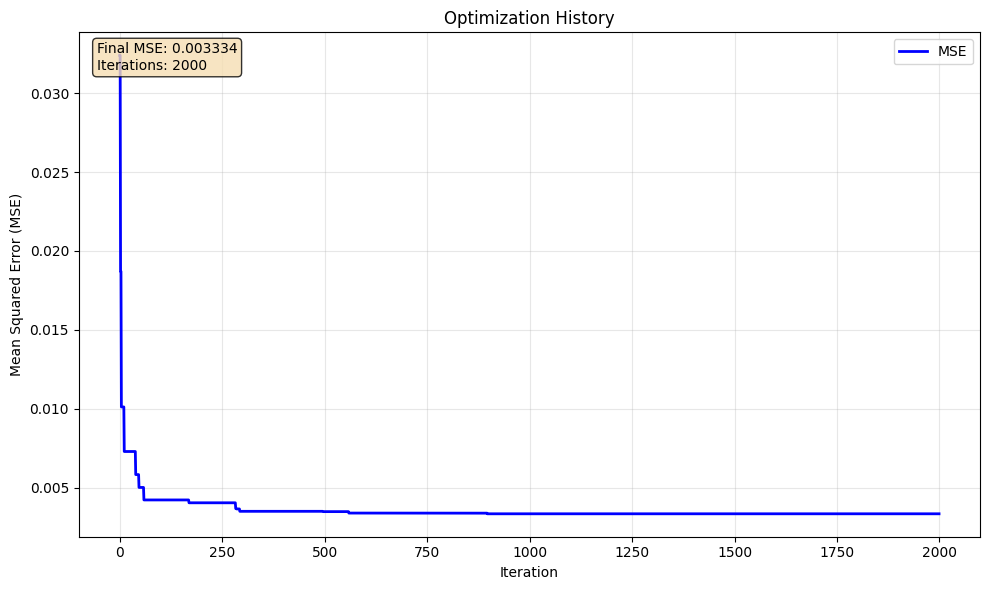

In [43]:
optimizer.plot_optimization_history(result)

In [54]:
# &, score_cutoff = 0.7
optimizer = Optimizer.ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned_reduced_PDPK1.csv', 
    config=config, 
    nodes_to_optimize=nodes_to_optimize, 
    verbose=True)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

2025-08-24 16:59:18,841 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimization attempt 1/2
Running PSO optimization...


PSO Setup:
  - Particles: 100
  - Max iterations: 2000
  - Problem dimensions: 71
  - Total function evaluations: 200000
  - Seed: 99


pyswarms.single.global_best:   0%|          |1/2000, best_cost=0.186/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))
pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=0.0228
2025-08-25 07:36:28,490 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.02283553041891547, best pos: [0.34925273 0.41301722 0.49865266 0.21716535 0.53739799 0.8225223
 0.29835084 0.25269149 0.62366983 0.29827301 0.11305547 0.8005743
 0.34416607 0.46887098 0.56287866 0.00676893 0.44358066 0.09724626
 0.61281963 0.40901435 0.34853502 0.39579891 0.00424555 0.57085335
 0.38613927 0.60663306 0.18962863 0.58268083 0.44418512 0.59257173
 0.60514797 0.41954978 0.71799682 0.43313996 0.64738132 0.45989414
 0.52658502 0.64408713 0.34453988 0.39048653 0.80991015 0.59533763
 0.77388149 0.52775684 0.703

Success threshold achieved: 0.022836 < 0.1

--- Optimization finished. Best MSE found: 0.022836 ---

--- Optimized PBN Rules ---
AKT1 = AktM & AktP, 0.4582
AKT1 = PDPK1 & PIK3CA, 0.5418
APAF1 = !BCL2L1, 0.6966
APAF1 = TP53, 0.3034
APC = !BIRC2 | ( APAF1 & CASP9 & Mito ), 0.3952
APC = APC, 0.6048
AktM = PDPK1 & PIP3, 1.0000
AktP = PDPK1 & PIP3, 1.0000
BAD = !AKT1 & BCL2L1, 0.6765
BAD = !AKT1 | !RPS6KA1 | TP53, 0.3235
BCL2L1 = !BAD & !BID & !MAPK8, 0.1237
BCL2L1 = !BAD | NFKB1 | STAT3 | !TP53, 0.8763
BID = !BCL2L1 | ( CASP8 & TP53 ) | ( MAPK8 & TP53 ), 0.4233
BID = CASP8, 0.5767
BIRC2 = !Mito | NFKB1 | ( !CASP3 & !CASP6 ), 0.9881
BIRC2 = TRAF2, 0.0119
CASP12 = CASP7, 1.0000
CASP3 = APC | !BIRC2 | CASP6 | CASP8, 0.9000
CASP3 = CASP8, 0.1000
CASP6 = !BIRC2 | CASP3, 0.1370
CASP6 = CASP8, 0.8630
CASP7 = APC | !BIRC2 | CASP8, 0.5399
CASP7 = CASP8, 0.4601
CASP8 = CASP6 & !CFLAR & !MAPK1, 0.9894
CASP8 = CASP6 | complexIIA | complexIIB, 0.0106
CASP9 = !AKT1 & APAF1, 0.5965
CASP9 = !AKT1 | !BIRC2

In [ ]:
config = {
    'pso_params': {
        'n_particles': 100,  # 20*number of parameters to optimize
        'iters': 2000,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': -1,
        'ftol_iter': 5
    },
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
    },
    'seed': 99,
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.1, # threshold for accepting fit,
    'display_rules_every': 100  # Display optimized rules every n iterations (0 = disabled)
}

# &, score_cutoff = 0.3
optimizer = Optimizer.ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned_reduced_PDPK1.csv', 
    config=config, 
    nodes_to_optimize=nodes_to_optimize, 
    verbose=True)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

2025-08-26 09:43:11,222 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimization attempt 1/2
Running PSO optimization...


PSO Setup:
  - Particles: 100
  - Max iterations: 2000
  - Problem dimensions: 74
  - Total function evaluations: 200000
  - Seed: 99


pyswarms.single.global_best:   0%|          |6/2000, best_cost=0.0512/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))
pyswarms.single.global_best:  42%|████▏     |832/2000, best_cost=0.0223

Simulating optimized model on all experimental conditions...
  Experiment 1: 1 nodes simulated
  Experiment 2: 1 nodes simulated
  Experiment 3: 1 nodes simulated
  Experiment 4: 1 nodes simulated
  Experiment 5: 1 nodes simulated
  Experiment 6: 1 nodes simulated
  Experiment 7: 1 nodes simulated
  Experiment 8: 1 nodes simulated
Simulation completed: 8 data points
Plot saved to AsPC1_AND_cutoff0/prediction_vs_experimental.png
Residual plot saved to AsPC1_AND_cutoff0/residual_analysis.png
Evaluation report saved to AsPC1_AND_cutoff0/evaluation_report.txt
Results exported to AsPC1_AND_cutoff0/detailed_results.csv


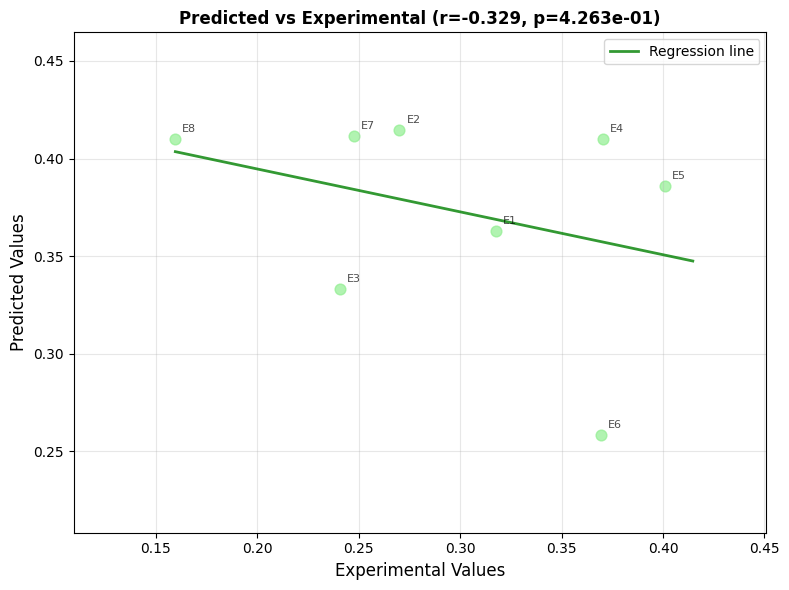

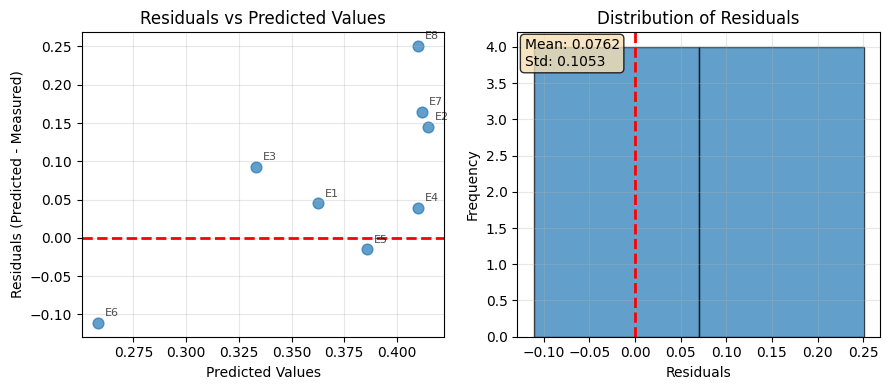

In [65]:
aspc1_pbn = optimizer.get_optimized_pbn(result)
np.random.seed(9)
output_dir = "AsPC1_AND_cutoff0"
evaluator = Optimizer.evaluate_optimization_result(
    result, 
    optimizer, 
    output_dir=output_dir,
    plot_residuals=True,
    save=True,
    detailed=True,
    figsize=(8, 6)
)

#### Without PDPK1

In [11]:
# AND, score_cutoff = 0.5
# Configure optimizer
config = {
    'pso_params': {
        'n_particles': 100,  # 20*number of parameters to optimize
        'iters': 1000,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': -1,
        'ftol_iter': 5
    },
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
    },
    'seed': 99,
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.1, # threshold for accepting fit,
    'display_rules_every': 100  # Display optimized rules every n iterations (0 = disabled)
}
optimizer = Optimizer.ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned_reduced.csv', 
    config=config, 
    nodes_to_optimize=None, 
    verbose=True)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

2025-08-26 22:39:03,923 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimization attempt 1/2
Running PSO optimization...


PSO Setup:
  - Particles: 100
  - Max iterations: 1000
  - Problem dimensions: 80
  - Total function evaluations: 100000
  - Seed: 99


pyswarms.single.global_best:   0%|          |0/1000/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=1.52e-5
2025-08-27 04:59:01,487 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.5224561944455992e-05, best pos: [0.36415372 0.48807733 0.50545412 0.57514154 0.43475931 0.42237164
 0.65144545 0.34778921 0.64901962 0.42515036 0.58827957 0.67484648
 0.51994495 0.49781816 0.43545117 0.44553776 0.24177979 0.69088111
 0.65530052 0.38167827 0.34110481 0.55812387 0.43864568 0.75176831
 0.11084784 0.63119809 0.4955117  0.4165374  0.41208748 0.49657882
 0.64649479 0.60511916 0.47823328 0.73761034 0.78006353 0.44161903
 0.69597332 0.28276504 0.47928278 0.63733036 0.08459966 0.65099078
 0.4443677  0.46778158 0.36394823 0.565

Success threshold achieved: 0.000015 < 0.1

--- Optimization finished. Best MSE found: 0.000015 ---

--- Optimized PBN Rules ---
AKT1 = !CASP3 & PDPK1 & PIK3CA & !PTEN, 0.4273
AKT1 = AktM & AktP, 0.5727
APAF1 = !BCL2L1, 0.4678
APAF1 = TP53, 0.5322
APC = !BIRC2 | ( APAF1 & CASP9 & Mito ), 0.5072
APC = APC, 0.4928
AktM = PDPK1 & PIP3, 1.0000
AktP = PDPK1 & PIP3, 1.0000
BAD = !AKT1 & BCL2L1 & CASP3 & !MAPK8 & !RAF1, 0.6042
BAD = !AKT1 | !RPS6KA1 | TP53, 0.3958
BCL2L1 = !BAD & !BID & !MAPK8, 0.4657
BCL2L1 = !BAD | NFKB1 | STAT3 | !TP53, 0.5343
BID = !BCL2L1 | ( CASP8 & TP53 ) | ( MAPK8 & TP53 ), 0.5109
BID = CASP8 & MAPK8 & TP53, 0.4891
BIRC2 = !Mito | NFKB1 | ( !CASP3 & !CASP6 ), 0.4943
BIRC2 = BIRC2, 0.5057
CASP12 = CASP7, 1.0000
CASP3 = APC | !BIRC2 | CASP6 | CASP8, 0.5132
CASP3 = CASP8 & CASP9, 0.4868
CASP6 = !BIRC2 | CASP3, 0.5281
CASP6 = CASP3 & CASP8, 0.4719
CASP7 = APC | !BIRC2 | CASP8, 0.5599
CASP7 = CASP8, 0.4401
CASP8 = CASP6 & !CFLAR & !MAPK1 & RIPK1, 0.8715
CASP8 = CASP6 | com

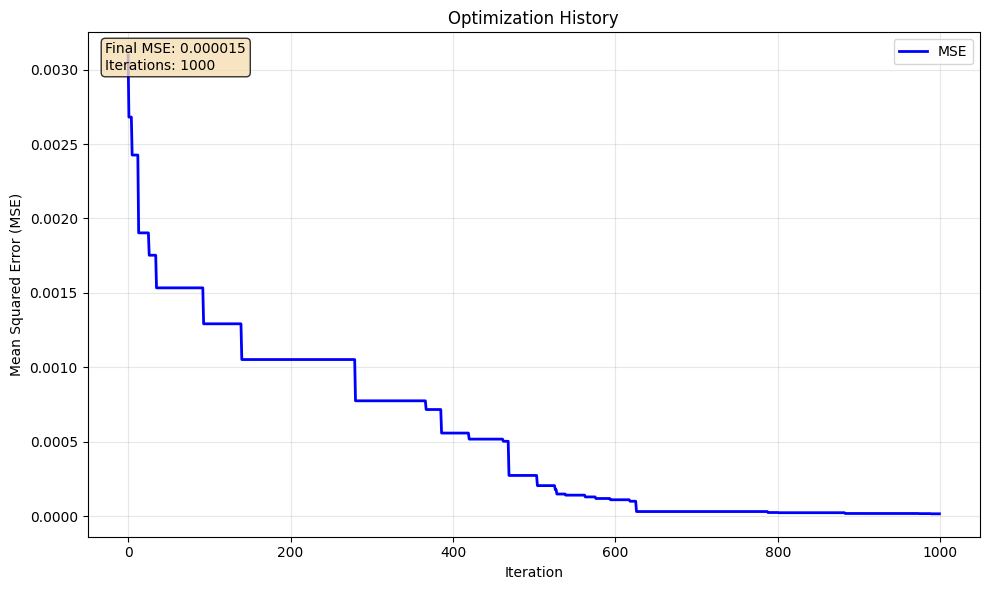

In [12]:
optimizer.plot_optimization_history(result)

Simulating optimized model on all experimental conditions...
  Experiment 1: 1 nodes simulated
  Experiment 2: 1 nodes simulated
  Experiment 3: 1 nodes simulated
  Experiment 4: 1 nodes simulated
  Experiment 5: 1 nodes simulated
  Experiment 6: 1 nodes simulated
  Experiment 7: 1 nodes simulated
Simulation completed: 7 data points
Plot saved to AsPC1_AND_cutoff0.5_7/prediction_vs_experimental.png
Residual plot saved to AsPC1_AND_cutoff0.5_7/residual_analysis.png
Evaluation report saved to AsPC1_AND_cutoff0.5_7/evaluation_report.txt
Results exported to AsPC1_AND_cutoff0.5_7/detailed_results.csv


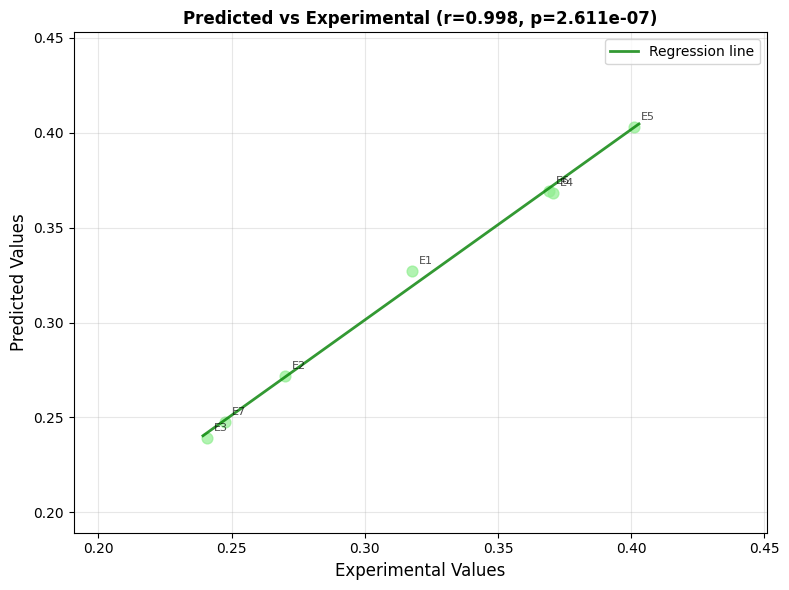

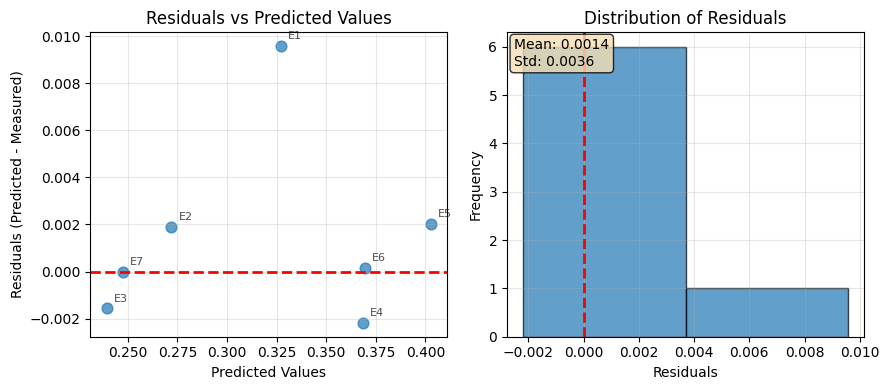

In [13]:
aspc1_pbn = optimizer.get_optimized_pbn(result)
np.random.seed(99)
output_dir = "AsPC1_AND_cutoff0.5_7"
evaluator = Optimizer.evaluate_optimization_result(
    result, 
    optimizer, 
    output_dir=output_dir,
    plot_residuals=True,
    save=True,
    detailed=True,
    figsize=(8, 6)
)

### for BxPC3

In [28]:
# Configure optimizer
config = {
    'pso_params': {
        'n_particles': 100,  # 20*number of parameters to optimize
        'iters': 1000,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': -1,
        'ftol_iter': 5
    },
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
        # 'method': 'monte_carlo',
        #     'monte_carlo_params': {
        #         'n_runs': 2,
        #         'n_steps': 5000,
        #         'p_noise': 0.05
        #     }
    },
    'seed': 99,
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.1, # threshold for accepting fit,
    'display_rules_every': 100  # Display optimized rules every n iterations (0 = disabled)
}
optimizer = Optimizer.ParameterOptimizer(pbn, '../data/Eduati2020_BxPC3_cleaned_reduced.csv', 
    config=config, 
    nodes_to_optimize=None, 
    verbose=True)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

2025-08-27 23:01:31,072 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimization attempt 1/2
Running PSO optimization...


PSO Setup:
  - Particles: 100
  - Max iterations: 1000
  - Problem dimensions: 80
  - Total function evaluations: 100000
  - Seed: 99


pyswarms.single.global_best:   0%|          |0/1000/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000416
2025-08-28 05:14:20,787 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0004155499574805245, best pos: [0.64926048 0.60209141 0.51286397 0.58243969 0.45989043 0.4685681
 0.55291964 0.36852145 0.3385716  0.66755441 0.40368943 0.81007991
 0.44963007 0.62209877 0.61199447 0.37267526 0.44469033 0.50013924
 0.39372306 0.5071416  0.49901738 0.17902529 0.50973514 0.59117486
 0.04061929 0.46235787 0.30555186 0.44665628 0.67739475 0.22275419
 0.29810766 0.59284172 0.17189411 0.68831895 0.43980662 0.46935731
 0.72571753 0.27504926 0.45446187 0.39114945 0.55629651 0.68954944
 0.63936295 0.47349215 0.14212827 0.6584

Success threshold achieved: 0.000416 < 0.1

--- Optimization finished. Best MSE found: 0.000416 ---

--- Optimized PBN Rules ---
AKT1 = !CASP3 & PDPK1 & PIK3CA & !PTEN, 0.5188
AKT1 = AktM & AktP, 0.4812
APAF1 = !BCL2L1, 0.4682
APAF1 = TP53, 0.5318
APC = !BIRC2 | ( APAF1 & CASP9 & Mito ), 0.4953
APC = APC, 0.5047
AktM = PDPK1 & PIP3, 1.0000
AktP = PDPK1 & PIP3, 1.0000
BAD = !AKT1 & BCL2L1 & CASP3 & !MAPK8 & !RAF1, 0.3365
BAD = !AKT1 | !RPS6KA1 | TP53, 0.6635
BCL2L1 = !BAD & !BID & !MAPK8, 0.3326
BCL2L1 = !BAD | NFKB1 | STAT3 | !TP53, 0.6674
BID = !BCL2L1 | ( CASP8 & TP53 ) | ( MAPK8 & TP53 ), 0.4195
BID = CASP8 & MAPK8 & TP53, 0.5805
BIRC2 = !Mito | NFKB1 | ( !CASP3 & !CASP6 ), 0.6215
BIRC2 = BIRC2, 0.3785
CASP12 = CASP7, 1.0000
CASP3 = APC | !BIRC2 | CASP6 | CASP8, 0.5595
CASP3 = CASP8 & CASP9, 0.4405
CASP6 = !BIRC2 | CASP3, 0.5040
CASP6 = CASP3 & CASP8, 0.4960
CASP7 = APC | !BIRC2 | CASP8, 0.2599
CASP7 = CASP8, 0.7401
CASP8 = CASP6 & !CFLAR & !MAPK1 & RIPK1, 0.9357
CASP8 = CASP6 | com

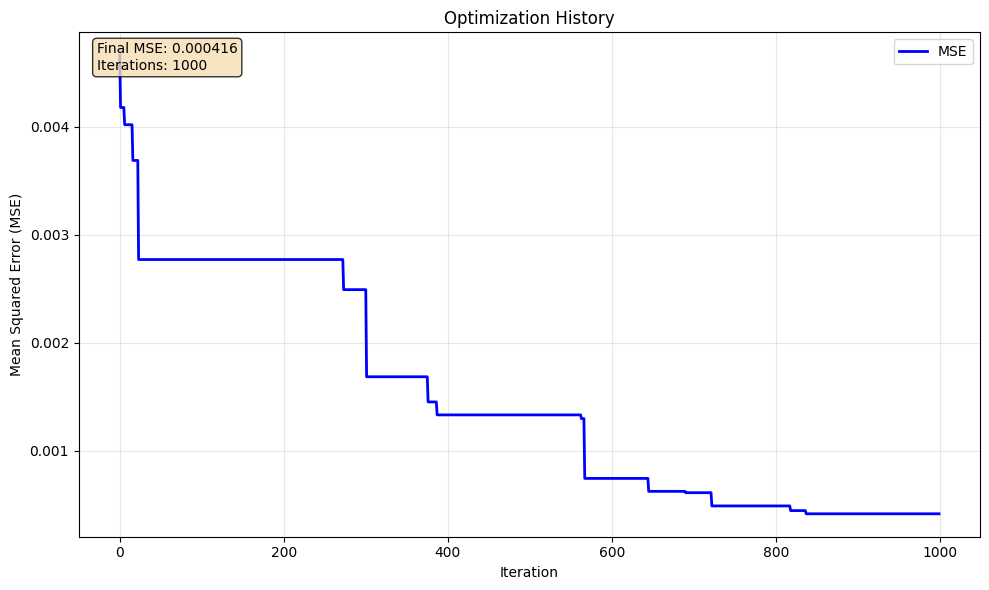

In [29]:
optimizer.plot_optimization_history(result)

Simulating optimized model on all experimental conditions...
  Experiment 1: 1 nodes simulated
  Experiment 2: 1 nodes simulated
  Experiment 3: 1 nodes simulated
  Experiment 4: 1 nodes simulated
  Experiment 5: 1 nodes simulated
  Experiment 6: 1 nodes simulated
  Experiment 7: 1 nodes simulated
Simulation completed: 7 data points
Plot saved to BxPC3_AND_cutoff0.5_7/prediction_vs_experimental.png
Residual plot saved to BxPC3_AND_cutoff0.5_7/residual_analysis.png
Evaluation report saved to BxPC3_AND_cutoff0.5_7/evaluation_report.txt
Results exported to BxPC3_AND_cutoff0.5_7/detailed_results.csv


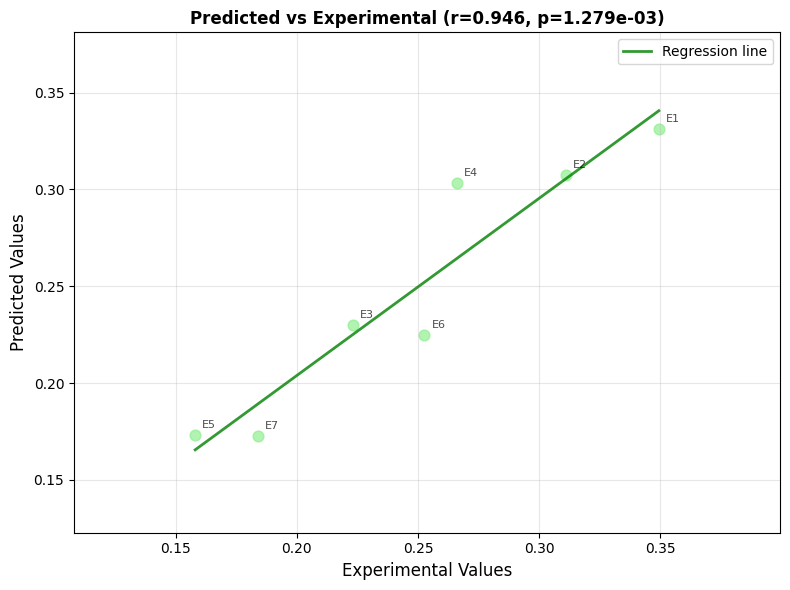

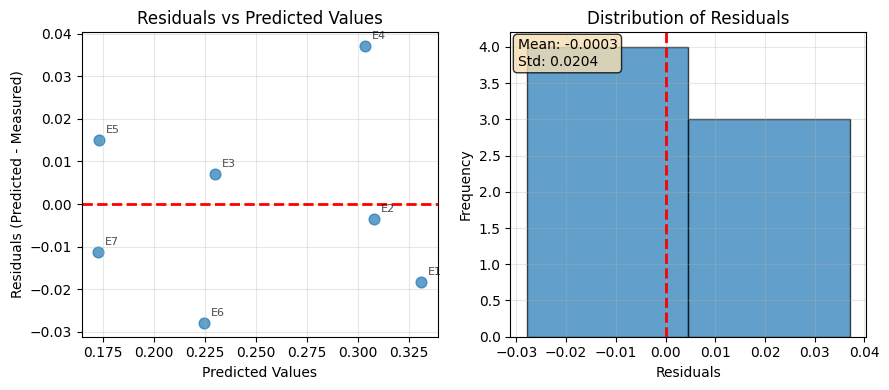

In [30]:
bxpc3_pbn = optimizer.get_optimized_pbn(result)
np.random.seed(99)
output_dir = "BxPC3_AND_cutoff0.5_7"
evaluator = Optimizer.evaluate_optimization_result(
    result, 
    optimizer, 
    output_dir=output_dir,
    plot_residuals=True,
    save=True,
    detailed=True,
    figsize=(8, 6)
)

# Correlation between optimized and measured data
## ASPC1

In [14]:
aspc1_pbn = optimizer.get_optimized_pbn(result)
measured_nodes, perturbed_nodes = Optimizer.extract_experiment_nodes(data_aspc1_file)
BNMPy.vis_network(aspc1_pbn,"AsPC1_optimized_7.html",interactive=True,measured_nodes=measured_nodes,perturbed_nodes=perturbed_nodes)

   Extracted 1 measured nodes: {'CASP3'}
   Extracted 8 perturbed nodes: {'AktM', 'MAP2K1', 'JAK1', 'PIK3CA', 'TNF', 'EGF', 'EGFR', 'IKBKB'}
Network visualization saved to AsPC1_optimized_7.html


In [9]:
optimized_string = """
AKT1 = !CASP3 & PDPK1 & PIK3CA & !PTEN, 0.4886
AKT1 = AktM & AktP, 0.5114
APAF1 = !BCL2L1, 0.2958
APAF1 = TP53, 0.7042
APC = !BIRC2 | ( APAF1 & CASP9 & Mito ), 0.5312
APC = APC, 0.4688
AktM = PDPK1 & PIP3, 1.0000
AktP = PDPK1 & PIP3, 1.0000
BAD = !AKT1 & BCL2L1 & CASP3 & !MAPK8 & !RAF1, 0.3577
BAD = !AKT1 | !RPS6KA1 | TP53, 0.6423
BCL2L1 = !BAD & !BID & !MAPK8, 0.3542
BCL2L1 = !BAD | NFKB1 | STAT3 | !TP53, 0.6458
BID = !BCL2L1 | ( CASP8 & TP53 ) | ( MAPK8 & TP53 ), 0.1701
BID = CASP8 & MAPK8 & TP53, 0.8299
BIRC2 = !Mito | NFKB1 | ( !CASP3 & !CASP6 ), 0.5570
BIRC2 = BIRC2, 0.4430
CASP12 = CASP7, 1.0000
CASP3 = APC | !BIRC2 | CASP6 | CASP8, 0.9000
CASP3 = CASP8 & CASP9, 0.1000
CASP6 = !BIRC2 | CASP3, 0.4386
CASP6 = CASP3 & CASP8, 0.5614
CASP7 = APC | !BIRC2 | CASP8, 0.5387
CASP7 = CASP8, 0.4613
CASP8 = CASP6 & !CFLAR & !MAPK1 & RIPK1, 0.9466
CASP8 = CASP6 | complexIIA | complexIIB, 0.0534
CASP9 = !AKT1 & APAF1 & !BCL2L1 & CASP3 & CASP8 & !MAPK1, 0.9084
CASP9 = !AKT1 | !BIRC2 | CASP12 | CASP3 | !MAPK1, 0.0916
CFLAR = !BIRC2, 0.4278
CFLAR = NFKB1, 0.5722
CTNNB1 = AKT1 & !APC & EGFR, 1.0000
EGF = EGF, 1.0000
EGFR = EGF & !MAPK1 & TP53, 0.5323
EGFR = EGF, 0.4677
IKBKB = AKT1 | PDPK1 | !TNFAIP3 | complexI, 0.4457
IKBKB = MAP3K1 & MAP3K14, 0.5543
JAK1 = EGFR, 1.0000
KRAS = SOS1, 1.0000
MAP2K1 = MAP3K1 & !MAPK1 & RAF1, 0.5261
MAP2K1 = PDPK1 | RAF1, 0.4739
MAP2K4 = !AKT1 & MAP3K1, 0.5125
MAP2K4 = !AKT1 | MAP3K1, 0.4875
MAP3K1 = KRAS | complexI, 0.4799
MAP3K1 = MAP3K1, 0.5201
MAP3K14 = !BIRC2, 0.5114
MAP3K14 = MAP3K14, 0.4886
MAPK1 = AKT1 & MAP2K1, 0.9319
MAPK1 = MAP2K1, 0.0681
MAPK8 = MAP2K4, 1.0000
MDM2 = AKT1 & TP53, 0.6196
MDM2 = AKT1 | TP53, 0.3804
Mito = !BCL2L1 | BID, 1.0000
NFKB1 = !IKBKB & !NFKBIA, 0.5687
NFKB1 = MAP3K14 | !NFKBIA, 0.4313
NFKBIA = !IKBKB & !TNFRSF1A, 0.5460
NFKBIA = !IKBKB | NFKB1, 0.4540
PDPK1 = PDPK1, 1.0000
PIK3CA = EGFR | KRAS, 0.6002
PIK3CA = KRAS & !PTEN, 0.3998
PIP3 = PIK3CA | !PTEN, 1.0000
PTEN = PTEN, 0.5403
PTEN = TP53, 0.4597
RAF1 = !AKT1 & KRAS & MAP2K1 & !MAPK1, 0.4667
RAF1 = KRAS, 0.5333
RIPK1 = !BIRC2 & !CASP8 & !TNFAIP3, 1.0000
RPS6KA1 = MAPK1 & PDPK1, 0.5077
RPS6KA1 = MAPK1, 0.4923
SOS1 = !MAPK1, 0.5386
SOS1 = EGFR | !MAPK1, 0.4614
STAT3 = EGFR & JAK1 & !MAPK1 & MAPK8, 0.3181
STAT3 = JAK1, 0.6819
TNF = TNF, 1.0000
TNFAIP3 = NFKB1, 0.5584
TNFAIP3 = TNFAIP3, 0.4416
TNFRSF1A = !MAPK1 & TNF, 0.4342
TNFRSF1A = NFKB1 | TNF, 0.5658
TP53 = IKBKB & MAPK1 & MAPK8 & !MDM2, 0.5909
TP53 = MAPK1 | MAPK8 | !MDM2, 0.4091
complexI = TNFRSF1A, 1.0000
complexIIA = !CFLAR | complexI, 1.0000
complexIIB = !BIRC2 | complexI, 1.0000
"""
config = {
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
        # 'method': 'monte_carlo',
        #     'monte_carlo_params': {
        #         'n_runs': 2,
        #         'n_steps': 100000,
        #         'p_noise': 0.05
        #     }
    },
    'seed': 99
}

aspc1_pbn = BNMPy.load_pbn_from_string(optimized_string)
report = Optimizer.evaluate_pbn(aspc1_pbn, '../data/Eduati2020_AsPC1_cleaned_reduced_PDPK1.csv', output_dir='AsPC1_AND_cutoff0.5/999', generate_plots=True, generate_report=True, config=config)

No initial state provided, using a random initial state
PBN loaded successfully. There are 48 genes in the network.
Evaluation report saved to AsPC1_AND_cutoff0.5/999/evaluation_report.txt
Results exported to AsPC1_AND_cutoff0.5/999/detailed_results.csv


In [34]:
import sys
import importlib
importlib.reload(sys.modules['Optimizer.result_evaluation'])
from Optimizer.result_evaluation import evaluate_optimization_result, evaluate_pbn

Simulating optimized model on all experimental conditions...
  Experiment 1: 1 nodes simulated
  Experiment 2: 1 nodes simulated
  Experiment 3: 1 nodes simulated
  Experiment 4: 1 nodes simulated
  Experiment 5: 1 nodes simulated
  Experiment 6: 1 nodes simulated
  Experiment 7: 1 nodes simulated
  Experiment 8: 1 nodes simulated
Simulation completed: 8 data points
Plot saved to AsPC1_AND_cutoff0.5/prediction_vs_experimental.png
Residual plot saved to AsPC1_AND_cutoff0.5/residual_analysis.png
Evaluation report saved to AsPC1_AND_cutoff0.5/evaluation_report.txt
Results exported to AsPC1_AND_cutoff0.5/detailed_results.csv


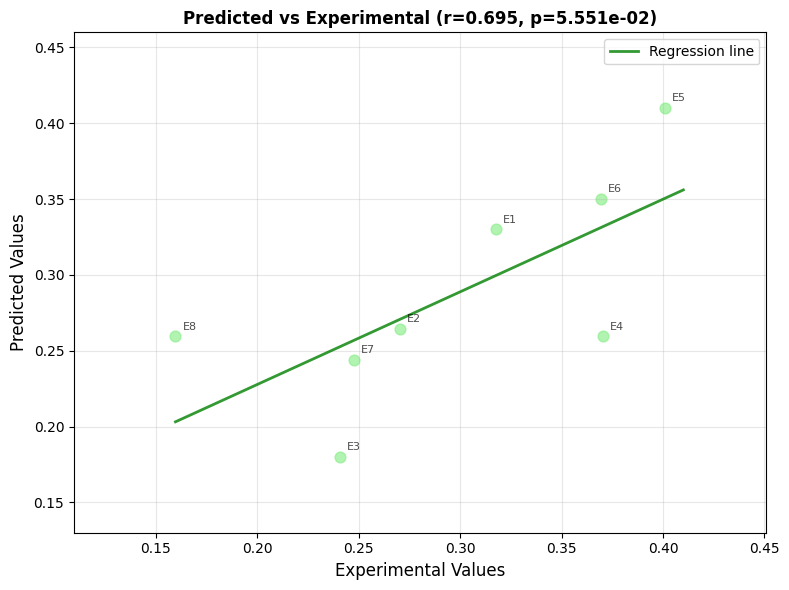

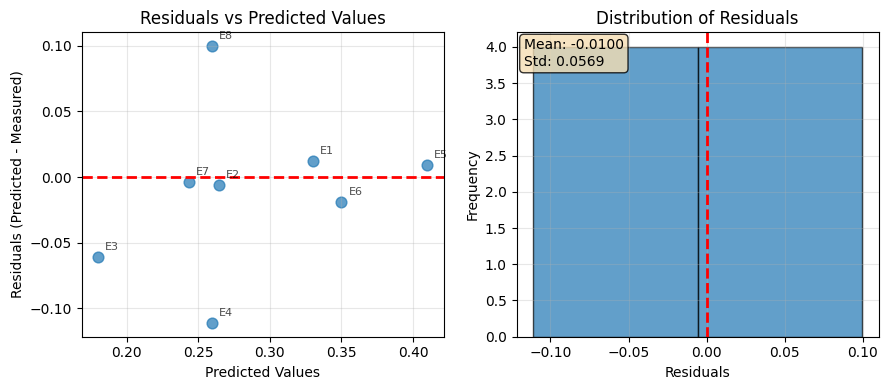

In [53]:
np.random.seed(99)
output_dir = "AsPC1_AND_cutoff0.5"
evaluator = Optimizer.evaluate_optimization_result(
    result, 
    optimizer, 
    output_dir=output_dir,
    plot_residuals=True,
    save=True,
    detailed=True,
    figsize=(8, 6)
)

In [ ]:
config = {
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
    #     'method': 'monte_carlo',
    #         'monte_carlo_params': {
    #             'n_runs': 2,
    #             'n_steps': 50000,
    #             'p_noise': 0.05
    #         }
    },
    'seed': 99
}
report = Optimizer.evaluate_pbn(aspc1_pbn, '../data/Eduati2020_AsPC1_cleaned.csv', output_dir='AsPC1_AND_cutoff0.5_7/Alldata', generate_plots=True, generate_report=True, config=config)

In [4]:
# Results using BN
with open(network_file, 'r') as f:
    bn_string = f.read()

pbn_string, nodes_to_optimize = BNMPy.BN2PBN(bn_string, prob=0.99)
pbn = BNMPy.load_pbn_from_string(pbn_string)

np.random.seed(99)
output_dir = "Original_BN"
report = Optimizer.evaluate_pbn(pbn, '../data/Eduati2020_AsPC1_cleaned_reduced_PDPK1.csv', output_dir=output_dir, generate_plots=True, generate_report=True, config=config)

No initial state provided, using a random initial state
PBN loaded successfully. There are 46 genes in the network.
Evaluation report saved to Original_BN/evaluation_report.txt
Results exported to Original_BN/detailed_results.csv


## BxPC3

In [31]:
bxpc3_pbn = optimizer.get_optimized_pbn(result)
measured_nodes, perturbed_nodes = Optimizer.extract_experiment_nodes('../data/Eduati2020_BxPC3_cleaned_reduced.csv')
BNMPy.vis_network(bxpc3_pbn,"BxPC3_optimized_7.html",interactive=True,measured_nodes=measured_nodes,perturbed_nodes=perturbed_nodes)

   Extracted 1 measured nodes: {'CASP3'}
   Extracted 8 perturbed nodes: {'AktM', 'MAP2K1', 'JAK1', 'PIK3CA', 'TNF', 'EGF', 'EGFR', 'IKBKB'}
Network visualization saved to BxPC3_optimized_7.html


In [33]:
config = {
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
    #     'method': 'monte_carlo',
    #         'monte_carlo_params': {
    #             'n_runs': 2,
    #             'n_steps': 50000,
    #             'p_noise': 0.05
    #         }
    },
    'seed': 99
}
report = Optimizer.evaluate_pbn(bxpc3_pbn, '../data/Eduati2020_BxPC3_cleaned.csv', output_dir='BxPC3_AND_cutoff0.5_7/Alldata', generate_plots=True, generate_report=True, config=config)

Evaluation report saved to BxPC3_AND_cutoff0.5_7/Alldata/evaluation_report.txt
Results exported to BxPC3_AND_cutoff0.5_7/Alldata/detailed_results.csv


# Simulate the optimized model

In [45]:
measured_nodes, perturbed_nodes = Optimizer.extract_experiment_nodes(data_aspc1_file)
perturbed_nodes

   Extracted 1 measured nodes: {'CASP3'}
   Extracted 8 perturbed nodes: {'TNF', 'PIK3CA', 'IKBKB', 'EGFR', 'AktM', 'EGF', 'MAP2K1', 'JAK1'}


{'AktM', 'EGF', 'EGFR', 'IKBKB', 'JAK1', 'MAP2K1', 'PIK3CA', 'TNF'}

In [15]:
import pandas as pd
import numpy as np
import itertools

inhibitors_genes = ['AktM','EGFR', 'IKBKB', 'JAK1', 'MAP2K1', 'PIK3CA','PDPK1,AktP']
stimuli_genes = ['EGF','TNF']
inhibitors = ['', 'AktM','EGFR', 'IKBKB', 'JAK1', 'MAP2K1', 'PIK3CA','PDPK1,AktP'] # also test on untreated
for combo in itertools.combinations(inhibitors_genes, 2): # pair-wise combinations of inhibitors
    inhibitors.append(','.join(combo))
stimuli = ['EGF','EGF,TNF'] 

print(f'inhibitors: {inhibitors}')
print(f'stimuli: {stimuli}')

inhibitors: ['', 'AktM', 'EGFR', 'IKBKB', 'JAK1', 'MAP2K1', 'PIK3CA', 'PDPK1,AktP', 'AktM,EGFR', 'AktM,IKBKB', 'AktM,JAK1', 'AktM,MAP2K1', 'AktM,PIK3CA', 'AktM,PDPK1,AktP', 'EGFR,IKBKB', 'EGFR,JAK1', 'EGFR,MAP2K1', 'EGFR,PIK3CA', 'EGFR,PDPK1,AktP', 'IKBKB,JAK1', 'IKBKB,MAP2K1', 'IKBKB,PIK3CA', 'IKBKB,PDPK1,AktP', 'JAK1,MAP2K1', 'JAK1,PIK3CA', 'JAK1,PDPK1,AktP', 'MAP2K1,PIK3CA', 'MAP2K1,PDPK1,AktP', 'PIK3CA,PDPK1,AktP']
stimuli: ['EGF', 'EGF,TNF']


In [16]:
df_results = pd.DataFrame()
np.random.seed(99)
for stimulus in stimuli:
    for inhibitor in inhibitors:
        calc = BNMPy.SteadyStateCalculator(aspc1_pbn)
        calc.set_experimental_conditions(stimuli=[stimulus],inhibitors=[inhibitor])
        steady_state = calc.compute_steady_state(
            method='tsmc',
            epsilon=0.05, # range of transition probability [Default=0.001]
            r=0.1, # range of accuracy (most sensitive) [Default=0.025]
            s=0.85, # probability to acquire defined accuracy [Default=0.95]
            p_mir=0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
            freeze_constant=True
            )
        conditions = [f"Stimulus:{stimulus}; Inhibitor:{inhibitor}"]
        df_steady_state = pd.DataFrame(steady_state,index=aspc1_pbn.nodeDict.keys(),columns=conditions).T
        df_results = pd.concat([df_results,df_steady_state])
df_results

,AKT1,APAF1,APC,AktM,AktP,BAD,BCL2L1,BID,BIRC2,CASP12,...,RPS6KA1,SOS1,STAT3,TNF,TNFAIP3,TNFRSF1A,TP53,complexI,complexIIA,complexIIB
Stimulus:EGF; Inhibitor:,0.003953,0.541502,0.296443,0.000000,0.023715,0.454545,0.565217,0.399209,0.830040,0.284585,...,0.142292,0.913043,0.470356,0.0,0.434783,0.312253,0.573123,0.312253,0.778656,0.438735
Stimulus:EGF; Inhibitor:AktM,0.015625,0.609375,0.343750,0.000000,0.015625,0.515625,0.468750,0.507812,0.820312,0.289062,...,0.148438,0.828125,0.562500,0.0,0.296875,0.234375,0.679688,0.234375,0.781250,0.382812
Stimulus:EGF; Inhibitor:EGFR,0.012107,0.302663,0.171913,0.024213,0.019370,0.476998,0.651332,0.203390,0.920097,0.249395,...,0.089588,0.571429,0.375303,0.0,0.135593,0.256659,0.242131,0.922518,0.271186,0.980630
Stimulus:EGF; Inhibitor:IKBKB,0.212871,0.287129,0.158416,0.212871,0.207921,0.420792,0.648515,0.178218,0.920792,0.311881,...,0.252475,0.514851,0.410891,1.0,0.198020,0.232673,0.306931,0.841584,0.222772,0.960396
Stimulus:EGF; Inhibitor:JAK1,0.007491,0.629213,0.393258,0.014981,0.018727,0.363296,0.471910,0.445693,0.805243,0.359551,...,0.134831,0.880150,0.003745,0.0,0.438202,0.273408,0.629213,0.280899,0.786517,0.423221
Stimulus:EGF; Inhibitor:MAP2K1,0.098160,0.349693,0.282209,0.128834,0.141104,0.503067,0.674847,0.220859,0.914110,0.398773,...,0.104294,0.619632,0.472393,0.0,0.159509,0.343558,0.368098,0.797546,0.349693,0.969325
Stimulus:EGF; Inhibitor:PIK3CA,0.010949,0.434307,0.284672,0.007299,0.018248,0.412409,0.456204,0.401460,0.799270,0.335766,...,0.080292,0.667883,0.645985,1.0,0.255474,0.416058,0.313869,0.974453,0.419708,0.974453
"Stimulus:EGF; Inhibitor:PDPK1,AktP",0.015385,0.588462,0.400000,0.003846,0.011538,0.396154,0.503846,0.392308,0.815385,0.350000,...,0.111538,0.903846,0.519231,0.0,0.365385,0.311538,0.611538,0.315385,0.730769,0.450000
"Stimulus:EGF; Inhibitor:AktM,EGFR",0.009259,0.490741,0.277778,0.009259,0.006173,0.391975,0.555556,0.419753,0.808642,0.311728,...,0.108025,0.882716,0.527778,0.0,0.333333,0.336420,0.577160,0.333333,0.774691,0.466049
"Stimulus:EGF; Inhibitor:AktM,IKBKB",0.012821,0.547009,0.482906,0.012821,0.000000,0.358974,0.508547,0.418803,0.717949,0.410256,...,0.149573,0.876068,0.576923,0.0,0.346154,0.311966,0.589744,0.311966,0.722222,0.525641


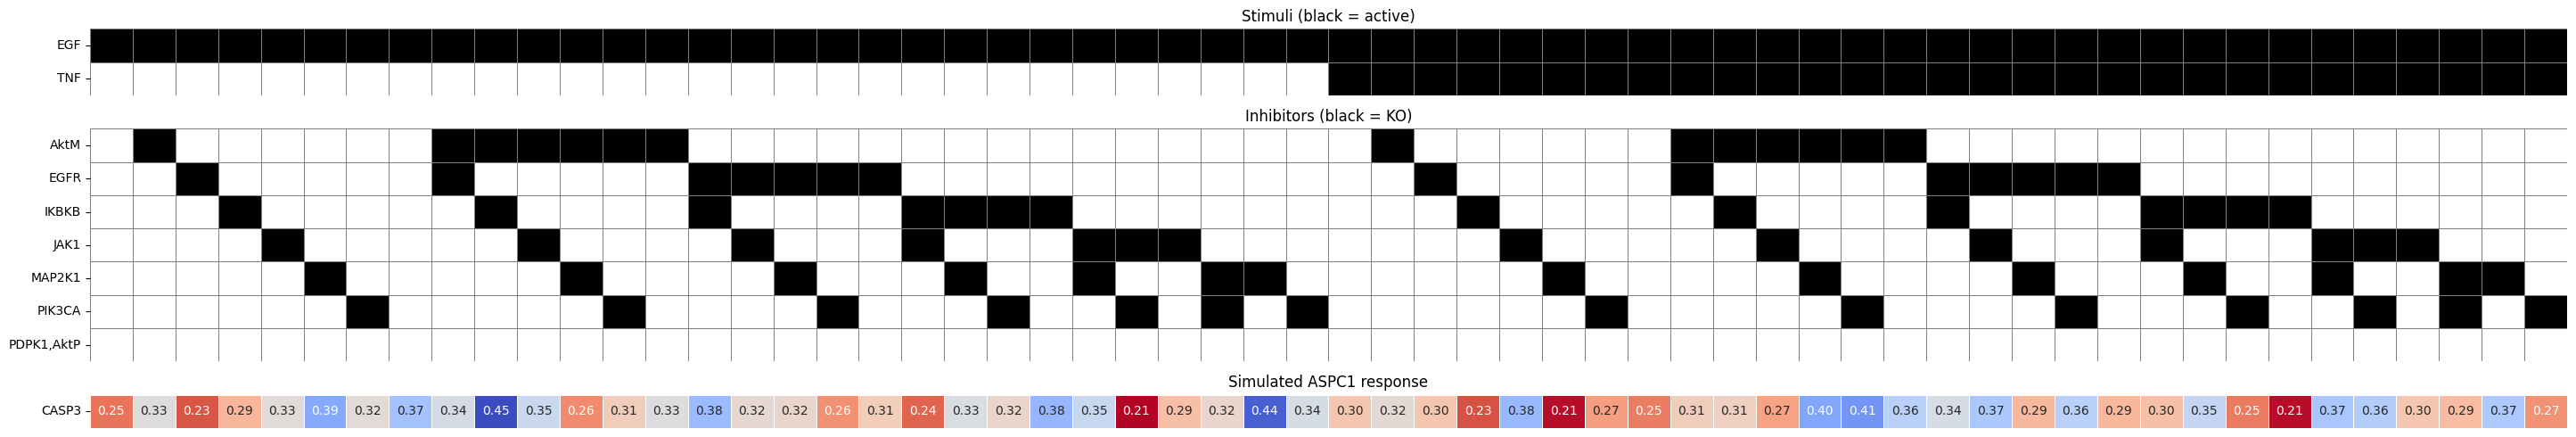

In [21]:
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Response genes and plot settings
response_genes = ['CASP3']
conditions = df_results.index.astype(str)

# Create binary matrices for stimuli and inhibitors
def create_binary_matrix(genes_list, conditions, pattern):
    """Create binary matrix from condition strings"""
    matrix = pd.DataFrame(0, index=genes_list, columns=conditions, dtype=int)
    for cond in conditions:
        match = re.search(pattern, cond)
        if match:
            genes = [g.strip() for g in match.group(1).split(',') 
                    if g.strip().lower() not in ['none', '']]
            for gene in genes:
                if gene in matrix.index:
                    matrix.loc[gene, cond] = 1
    return matrix

stimuli_block = create_binary_matrix(stimuli_genes, conditions, r"Stimulus:([^;]+)")
inhibitors_block = create_binary_matrix(inhibitors_genes, conditions, r"Inhibitor:([^;]+)")
response_block = df_results[response_genes].T

# Plot settings
bw = ListedColormap(['white', 'black'])
heat = sns.color_palette('coolwarm_r', as_cmap=True)
vmin, vmax = response_block.values.min(), response_block.values.max()

# Create the heatmap plot
heights = [len(stimuli_block), len(inhibitors_block), len(response_block)]
fig, axes = plt.subplots(3, 1, figsize=(0.5 * df_results.shape[0], 0.5 * sum(heights)),
                        sharex=True, gridspec_kw={'height_ratios': heights})

# Plot each section
plot_configs = [
    (stimuli_block, "Stimuli (black = active)", axes[0], bw, 0, 1, False),
    (inhibitors_block, "Inhibitors (black = KO)", axes[1], bw, 0, 1, False),
    (response_block, "Simulated ASPC1 response", axes[2], heat, vmin, vmax, True)
]

for data, title, ax, cmap, v_min, v_max, annotate in plot_configs:
    sns.heatmap(data, cmap=cmap, vmin=v_min, vmax=v_max, ax=ax, cbar=False,
                linewidths=.5, linecolor='grey' if cmap == bw else 'white',
                annot=annotate, fmt='.2f' if annotate else '')
    ax.set_title(title)
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

for ax in axes:
    ax.tick_params(axis='x', rotation=45, labelsize=8)

plt.tight_layout()
plt.show()

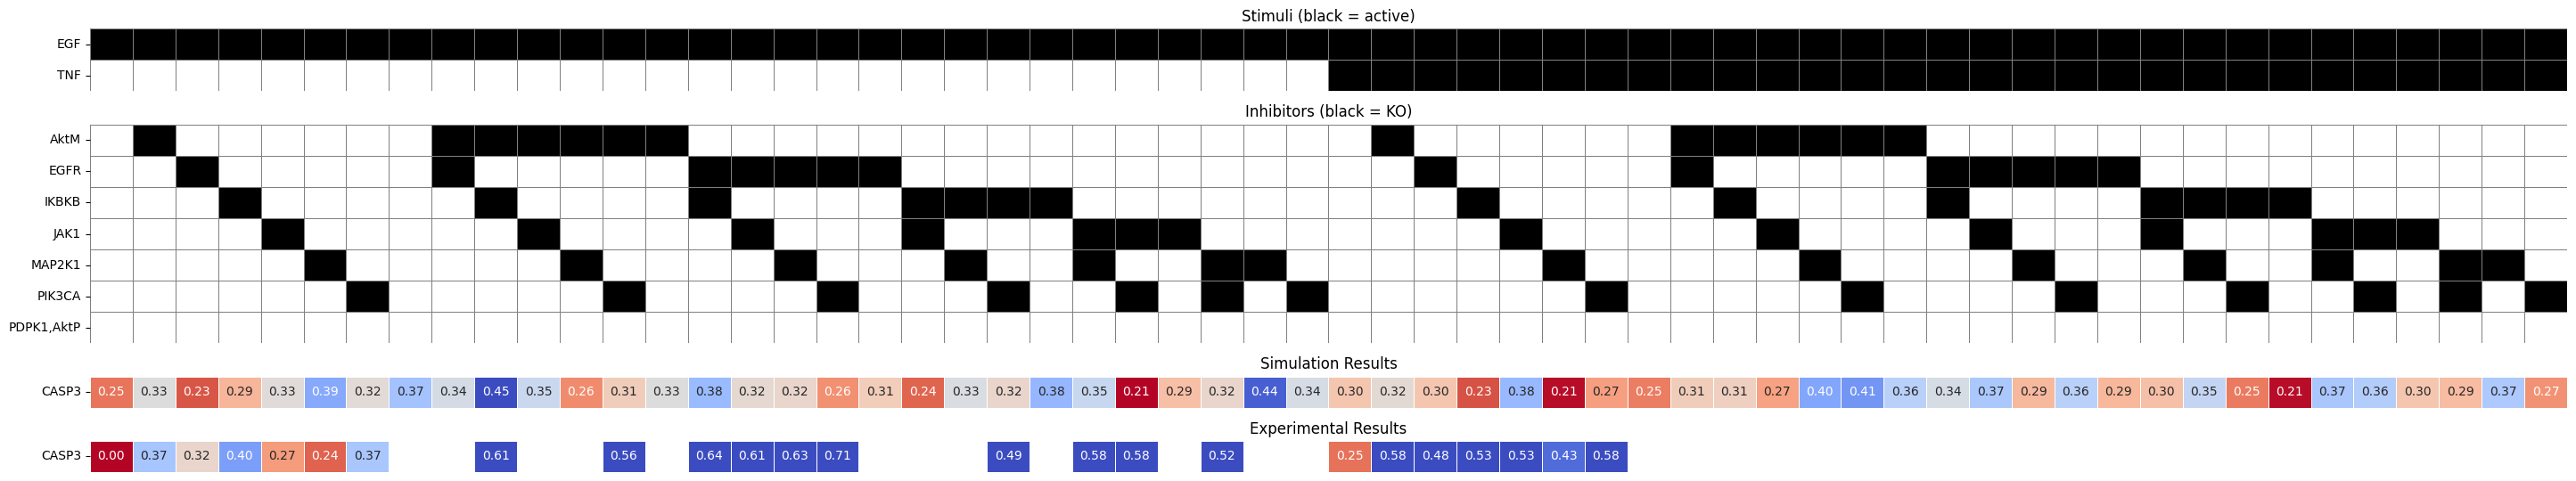

In [17]:
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Response genes and plot settings
response_genes = ['CASP3']
conditions = df_results.index.astype(str)

# Create binary matrices for stimuli and inhibitors (existing code)
def create_binary_matrix(genes_list, conditions, pattern):
    """Create binary matrix from condition strings"""
    matrix = pd.DataFrame(0, index=genes_list, columns=conditions, dtype=int)
    for cond in conditions:
        match = re.search(pattern, cond)
        if match:
            genes = [g.strip() for g in match.group(1).split(',') 
                    if g.strip().lower() not in ['none', '']]
            for gene in genes:
                if gene in matrix.index:
                    matrix.loc[gene, cond] = 1
    return matrix

stimuli_block = create_binary_matrix(stimuli_genes, conditions, r"Stimulus:([^;]+)")
inhibitors_block = create_binary_matrix(inhibitors_genes, conditions, r"Inhibitor:([^;]+)")
response_block = df_results[response_genes].T

# Process experimental data to create experimental block
def create_experimental_block(data_aspc1, conditions, target_gene='CASP3'):
    """Create experimental results matrix from data_aspc1"""
    exp_matrix = pd.DataFrame(np.nan, index=[target_gene], columns=conditions)
    
    for exp in data_aspc1:
        # Convert stimuli and inhibitors lists to strings
        stimuli_str = ','.join(exp['stimuli']) if exp['stimuli'] else 'none'
        inhibitors_str = ','.join(exp['inhibitors']) if exp['inhibitors'] else ''
        
        # Create condition string to match df_results format
        condition = f"Stimulus:{stimuli_str}; Inhibitor:{inhibitors_str}"
        
        # If this condition exists in our simulation results, add experimental value
        if condition in conditions:
            if target_gene in exp['measurements']:
                exp_matrix.loc[target_gene, condition] = exp['measurements'][target_gene]
    
    return exp_matrix
    
data_aspc1 = Optimizer.ExperimentData.load_from_csv("../data/Eduati2020_AsPC1_cleaned.csv")
experimental_block = create_experimental_block(data_aspc1, conditions, 'CASP3')

# Plot settings
bw = ListedColormap(['white', 'black'])
heat = sns.color_palette('coolwarm_r', as_cmap=True)
vmin, vmax = response_block.values.min(), response_block.values.max()

# Create the enhanced heatmap plot with experimental data
heights = [len(stimuli_block), len(inhibitors_block), len(response_block), len(experimental_block)]
fig, axes = plt.subplots(4, 1, figsize=(0.5 * df_results.shape[0], 0.5 * sum(heights)),
                        sharex=True, gridspec_kw={'height_ratios': heights})

# Plot each section
plot_configs = [
    (stimuli_block, "Stimuli (black = active)", axes[0], bw, 0, 1, False),
    (inhibitors_block, "Inhibitors (black = KO)", axes[1], bw, 0, 1, False),
    (response_block, "Simulation Results", axes[2], heat, vmin, vmax, True),
    (experimental_block, "Experimental Results", axes[3], heat, vmin, vmax, True)
]

for data, title, ax, cmap, v_min, v_max, annotate in plot_configs:
    sns.heatmap(data, cmap=cmap, vmin=v_min, vmax=v_max, ax=ax, cbar=False,
                linewidths=.5, linecolor='grey' if cmap == bw else 'white',
                annot=annotate, fmt='.2f' if annotate else '')
    ax.set_title(title)
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

for ax in axes:
    ax.tick_params(axis='x', rotation=45, labelsize=8)

plt.tight_layout()
plt.show()

In [20]:
config = {
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
    #     'method': 'monte_carlo',
    #         'monte_carlo_params': {
    #             'n_runs': 2,
    #             'n_steps': 50000,
    #             'p_noise': 0.05
    #         }
    },
    'seed': 99
}
report = Optimizer.evaluate_pbn(aspc1_pbn, '../data/Eduati2020_AsPC1_cleaned.csv', output_dir='AsPC1_AND_cutoff0.5_7/Alldata', generate_plots=True, generate_report=True, config=config)

Evaluation report saved to AsPC1_AND_cutoff0.5_7/Alldata/evaluation_report.txt
Results exported to AsPC1_AND_cutoff0.5_7/Alldata/detailed_results.csv


# AsPC1 vs BxPC3

In [2]:
aspc1_pbn = BNMPy.load_pbn_from_file('AsPC1_AND_cutoff0.5_7/aspc1_optimized.txt')
bxpc3_pbn = BNMPy.load_pbn_from_file('BxPC3_AND_cutoff0.5_7/bxpc3_optimized.txt')

No initial state provided, using a random initial state
PBN loaded successfully. There are 48 genes in the network.
No initial state provided, using a random initial state
PBN loaded successfully. There are 48 genes in the network.


In [3]:
aspc1_cij = aspc1_pbn.cij
bxpc3_cij = bxpc3_pbn.cij
nodes = aspc1_pbn.nodeDict.keys()

# Compute the absolute difference for each node
diff_dict = {}
for i, node in enumerate(nodes):
    aspc1_vals = aspc1_cij[i]
    bxpc3_vals = bxpc3_cij[i]
    diff = np.abs(aspc1_vals - bxpc3_vals)
    # For ranking, use the sum of absolute differences for the node
    diff_sum = np.sum(diff)
    diff_dict[node] = {
        'aspc1_cij': aspc1_vals,
        'bxpc3_cij': bxpc3_vals,
        'diff_sum': diff_sum
    }

# Rank nodes from largest to smallest difference
ranked = sorted(diff_dict.items(), key=lambda x: x[1]['diff_sum'], reverse=True)

# Prepare the output dictionary as requested
output_dict = {node: {'aspc1_cij': vals['aspc1_cij'], 'bxpc3_cij': vals['bxpc3_cij']} for node, vals in ranked}

output_dict


{'MDM2': {'aspc1_cij': array([0.337, 0.663]),
  'bxpc3_cij': array([0.8096, 0.1904])},
 'MAP2K4': {'aspc1_cij': array([0.8828, 0.1172]),
  'bxpc3_cij': array([0.4128, 0.5872])},
 'SOS1': {'aspc1_cij': array([0.3231, 0.6769]),
  'bxpc3_cij': array([0.7306, 0.2694])},
 'CASP7': {'aspc1_cij': array([0.5599, 0.4401]),
  'bxpc3_cij': array([0.2599, 0.7401])},
 'TNFRSF1A': {'aspc1_cij': array([0.2369, 0.7631]),
  'bxpc3_cij': array([0.5316, 0.4684])},
 'NFKBIA': {'aspc1_cij': array([0.4911, 0.5089]),
  'bxpc3_cij': array([0.7724, 0.2276])},
 'BAD': {'aspc1_cij': array([0.6042, 0.3958]),
  'bxpc3_cij': array([0.3365, 0.6635])},
 'EGFR': {'aspc1_cij': array([0.5586, 0.4414]),
  'bxpc3_cij': array([0.7752, 0.2248])},
 'MAP3K14': {'aspc1_cij': array([0.5624, 0.4376]),
  'bxpc3_cij': array([0.7691, 0.2309])},
 'TP53': {'aspc1_cij': array([0.3924, 0.6076]),
  'bxpc3_cij': array([0.5374, 0.4626])},
 'TNFAIP3': {'aspc1_cij': array([0.4338, 0.5662]),
  'bxpc3_cij': array([0.2928, 0.7072])},
 'BCL2L1'

## MSE sensitivity

In [14]:
import sys
import importlib
importlib.reload(sys.modules['Optimizer.sensitivity_analysis'])

<module 'Optimizer.sensitivity_analysis' from '/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/Optimizer/sensitivity_analysis.py'>

PBN MSE SENSITIVITY ANALYSIS

Network information:
  - Total nodes: 48
  - Measured nodes: 1 (CASP3)
  - Analyzable nodes: 32
  - Experiments: 7
  - Baseline MSE: 0.000015

Running One-at-a-Time MSE sensitivity analysis...
  - Perturbation magnitude: 0.1
  Progress: 0/32
  Progress: 5/32
  Progress: 10/32
  Progress: 15/32
  Progress: 20/32
  Progress: 25/32
  Progress: 30/32

Identifying top 5 sensitive nodes...

Top 5 sensitive nodes (by average sensitivity score):
------------------------------------------------------------
1. CASP8           - Avg: 569.9406, Max: 569.9406, Std: nan
2. CASP3           - Avg: 335.7716, Max: 335.7716, Std: nan
3. BIRC2           - Avg: 139.8169, Max: 139.8169, Std: nan
4. IKBKB           - Avg: 103.7967, Max: 103.7967, Std: nan
5. CASP9           - Avg: 67.9031, Max: 67.9031, Std: nan

MSE change details for top nodes:
------------------------------------------------------------

CASP8:
  Average MSE change: +0.008677
  Average relative change: +56994

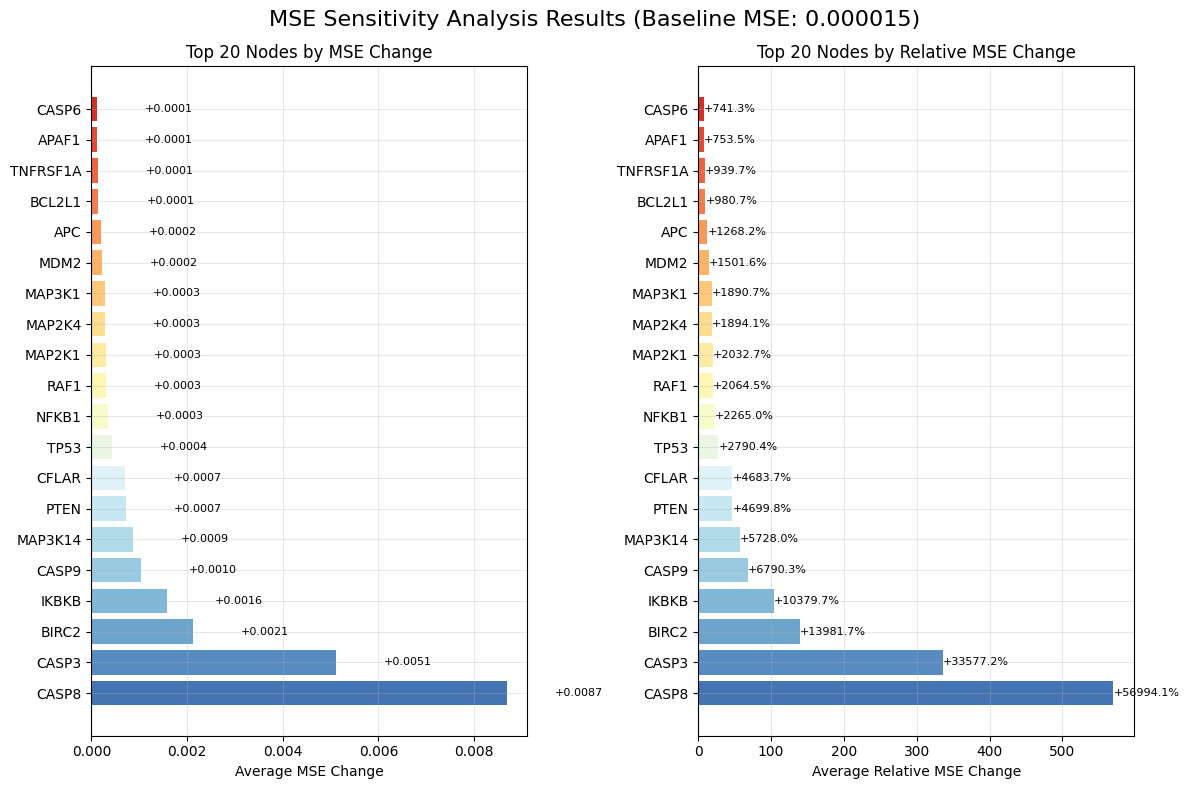

In [15]:
from Optimizer.sensitivity_analysis import mse_sensitivity_analysis, plot_mse_sensitivity_results
config = {
    'perturbation_magnitude': 0.1,  # How much to perturb probabilities (0.1-0.5)
    'seed': 99,
    'steady_state': {
        'method': 'tsmc',  # or 'monte_carlo'
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
    }
}
# AsPC1
results = mse_sensitivity_analysis(
    aspc1_pbn, 
    Optimizer.ExperimentData.load_from_csv(data_aspc1_file), 
    config=config,
    top_n=5
)

# Get results
top_nodes = results['top_nodes']
sensitivity_df = results['sensitivity_df']
baseline_mse = results['baseline_mse']
experiment_errors = results['experiment_errors']

# Visualize results
plot_mse_sensitivity_results(
    sensitivity_df, 
    baseline_mse, 
    top_n=20,
    save_path='AsPC1_AND_cutoff0.5_7/mse_sensitivity_aspc1.png'
)

PBN MSE SENSITIVITY ANALYSIS

Network information:
  - Total nodes: 48
  - Measured nodes: 1 (CASP3)
  - Analyzable nodes: 32
  - Experiments: 7
  - Baseline MSE: 0.000416

Running One-at-a-Time MSE sensitivity analysis...
  - Perturbation magnitude: 0.1
  Progress: 0/32
  Progress: 5/32
  Progress: 10/32
  Progress: 15/32
  Progress: 20/32
  Progress: 25/32
  Progress: 30/32

Identifying top 5 sensitive nodes...

Top 5 sensitive nodes (by average sensitivity score):
------------------------------------------------------------
1. CASP8           - Avg: 30.3815, Max: 30.3815, Std: nan
2. CASP3           - Avg: 3.9750, Max: 3.9750, Std: nan
3. MAPK1           - Avg: 3.5437, Max: 3.5437, Std: nan
4. CASP9           - Avg: 2.7442, Max: 2.7442, Std: nan
5. NFKB1           - Avg: 2.7210, Max: 2.7210, Std: nan

MSE change details for top nodes:
------------------------------------------------------------

CASP8:
  Average MSE change: +0.012625
  Average relative change: +3038.15%

CASP3:
  Av

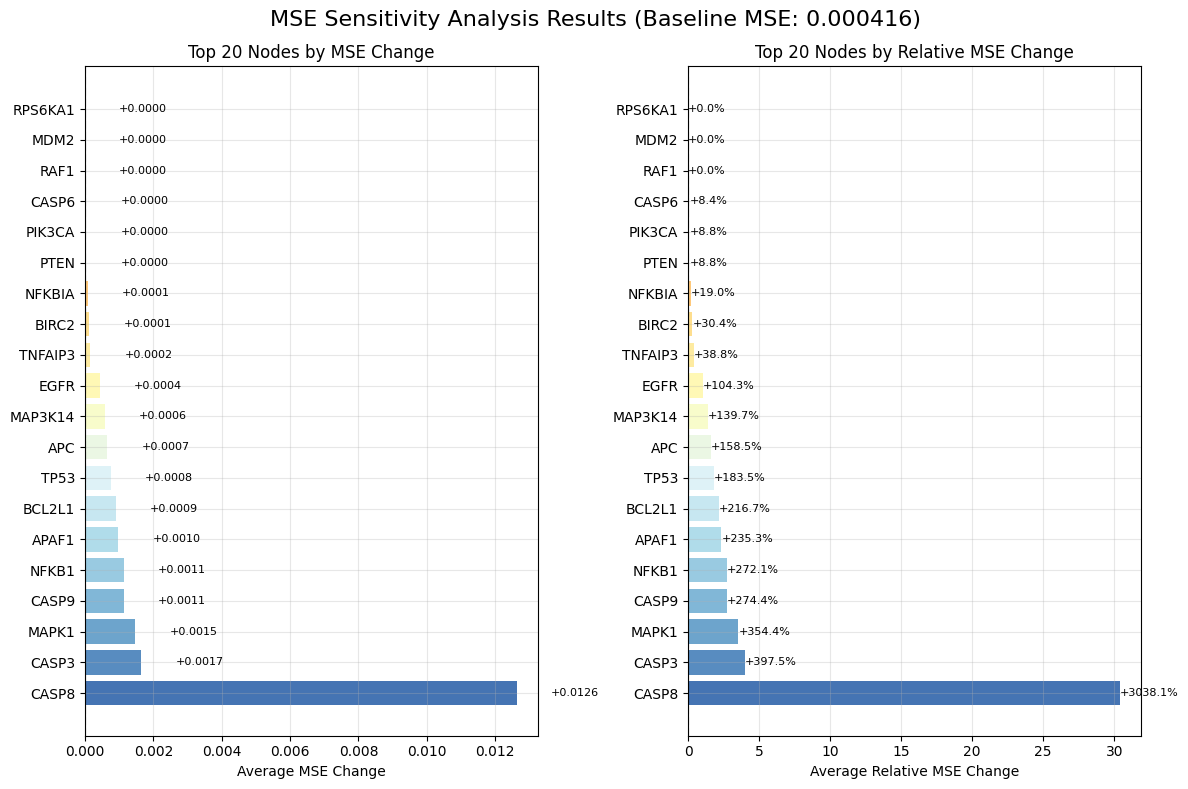

In [16]:
# BxPC3 
results = mse_sensitivity_analysis(
    bxpc3_pbn, 
    Optimizer.ExperimentData.load_from_csv(data_bxpc3_file), 
    config=config,
    top_n=5
)

# Get results
top_nodes = results['top_nodes']
sensitivity_df = results['sensitivity_df']
baseline_mse = results['baseline_mse']
experiment_errors = results['experiment_errors']

# Visualize results
plot_mse_sensitivity_results(
    sensitivity_df, 
    baseline_mse, 
    top_n=20,
    save_path='BxPC3_AND_cutoff0.5_7/mse_sensitivity_bxpc3.png'
)